## FINTECH FINAL PROJECT GROUP 10 AY-24/25 : EARLY WARNING SYSTEM WITH ANOMALY DETECTION

In [60]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.metrics import precision_score, recall_score, f1_score

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Mount Google Drive to access files
# Skip remounting if already mounted

In [61]:

# Define the path to the dataset
file_path = 'Dataset4_EWS.xlsx'

In [62]:
# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Load the data from the Excel file
# First sheet contains market data with dates and anomaly labels, second sheet contains metadata
data_df = pd.read_excel(file_path, sheet_name='Markets')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# Check the structure of the loaded data
print("Data columns:", data_df.columns.tolist())

# Extract date and anomaly label columns
date_col = 'Date' if 'Date' in data_df.columns else data_df.columns[0]
y_col = 'Y' if 'Y' in data_df.columns else None

# Convert dates to datetime format
data_df[date_col] = pd.to_datetime(data_df[date_col], dayfirst=True)  # Date format is dd/mm/yy

# Set date as index
data_df = data_df.set_index(date_col)
# Extract features (all columns except Y if it exists)
if y_col:
    X_df = data_df.drop(y_col, axis=1)
    y = data_df[y_col].values
else:
    X_df = data_df
    y = None

# Display basic information about the dataset
print(f"Data shape: {X_df.shape}")
print(f"Total number of records: {len(X_df)}")
print(f"Time period: from {X_df.index.min().strftime('%m/%d/%Y')} to {X_df.index.max().strftime('%m/%d/%Y')}")
print(f"Frequency: {pd.infer_freq(X_df.index) or 'Weekly'}")
print(f"Number of variables: {X_df.shape[1]}")
if y_col:
    print(f"Number of anomalies: {np.sum(y == 1)} ({np.mean(y == 1)*100:.2f}%)")

# Create a more comprehensive metadata table with additional statistics
enhanced_metadata = []

# Determine the correct column names for ticker and description
ticker_col = 'ticker' if 'ticker' in metadata_df.columns else metadata_df.columns[0]
desc_col = 'description' if 'description' in metadata_df.columns else metadata_df.columns[1] if len(metadata_df.columns) > 1 else ticker_col

for ticker in X_df.columns:
    # Get metadata for this ticker if available
    meta_row = metadata_df[metadata_df[ticker_col] == ticker] if ticker in metadata_df[ticker_col].values else pd.DataFrame()

    # Get description or use ticker if not found
    description = meta_row[desc_col].values[0] if not meta_row.empty and desc_col in meta_row.columns else ticker

    # Calculate statistics for this series
    series = X_df[ticker]
enhanced_metadata.append({
        'Ticker': ticker,
        'Description': description,
        'Mean': series.mean(),
        'Std.Dev': series.std(),
        'Min': series.min(),
        'Max': series.max(),
        'Missing values': series.isna().sum(),
        'Missing (%)': f"{series.isna().mean()*100:.2f}%"
    })

# Create enhanced metadata dataframe
enhanced_meta_df = pd.DataFrame(enhanced_metadata)

# Display the enhanced metadata
print("\nMetadata and statistics:")
display(enhanced_meta_df)


Data columns: ['Data', 'BDIY', 'CRY', 'Cl1', 'DXY', 'ECSURPUS', 'EMUSTRUU', 'EONIA', 'GBP', 'GT10', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y', 'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR', 'JPY', 'LF94TRUU', 'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU', 'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'US0001M', 'USGG2YR', 'USGG30YR', 'USGG3M', 'VIX', 'XAUBGNL', 'Y']
Data shape: (1111, 42)
Total number of records: 1111
Time period: from 01/11/2000 to 04/20/2021
Frequency: W-TUE
Number of variables: 42
Number of anomalies: 237 (21.33%)

Metadata and statistics:


,Ticker,Description,Mean,Std.Dev,Min,Max,Missing values,Missing (%)
0,XAUBGNL,XAUBGNL,987.463744,494.62374,256.68,2006.91,0,0.00%


In [63]:
# Make data stationary based on variable type
# So w define lists of variables by type
indices_currencies = [col for col in X_df.columns if col in [
    'XAUBGNL', 'BDIY', 'CRY', 'Cl1', 'DXY', 'EMUSTRUU', 'GBP', 'JPY', 'LF94TRUU',
    'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU',
    'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'VIX'
]]

interest_rates = [col for col in X_df.columns if col in [
    'EONIA', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y',
    'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR',
    'US0001M', 'USGG3M', 'USGG2YR', 'GT10', 'USGG30YR'
]]

# Create a new dataframe for stationary data
stationary_df = pd.DataFrame(index=X_df.index[1:])

# Apply log-differences to indices and currencies (always positive)
for col in indices_currencies:
    if col in X_df.columns:
        stationary_df[col] = np.diff(np.log(X_df[col]))

# Apply first differences to interest rates (can be negative or very close to 0)
for col in interest_rates:
    if col in X_df.columns:
        stationary_df[col] = np.diff(X_df[col])

# Keep Bloomberg Economic US Surprise Index as is (already stationary)
if 'ECSURPUS' in X_df.columns:
    stationary_df['ECSURPUS'] = X_df['ECSURPUS'].values[1:]

# Adjust the response variable to match the new data length
if y is not None:
    y_stationary = y[1:]
else:
    y_stationary = None


In [64]:
# Step 1: shuffle and split data into training, validation, and test sets
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# Convert to numpy arrays for easier manipulation
X = stationary_df.values
y = y_stationary

# Step 1: Creating training/cross-validation/test set with reshuffling

# Reshuffle the data (this will break down autocorrelation)
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

# Separate normal and anomalous examples
X_normal = X_shuffled[y_shuffled == 0]
X_anomaly = X_shuffled[y_shuffled == 1]

# Calculate sizes for each set
n_normal = X_normal.shape[0]
n_anomaly = X_anomaly.shape[0]

# Training set: 80% of normal examples
train_size = int(0.8 * n_normal)
X_train = X_normal[:train_size]
y_train = np.zeros(train_size)

# Cross-validation set: 10% of normal examples and 50% of anomalies
cv_normal_size = int(0.1 * n_normal)
cv_anomaly_size = int(0.5 * n_anomaly)
X_cv_normal = X_normal[train_size:train_size + cv_normal_size]
X_cv_anomaly = X_anomaly[:cv_anomaly_size]
X_cross_val = np.vstack((X_cv_normal, X_cv_anomaly))
y_cross_val = np.hstack((np.zeros(cv_normal_size), np.ones(cv_anomaly_size)))

# Test set: 10% of normal examples and 50% of anomalies
X_test_normal = X_normal[train_size + cv_normal_size:]
X_test_anomaly = X_anomaly[cv_anomaly_size:]
X_test = np.vstack((X_test_normal, X_test_anomaly))
y_test = np.hstack((np.zeros(len(X_test_normal)), np.ones(len(X_test_anomaly))))

# We'll standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_cross_val = scaler.transform(X_cross_val)
X_test = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]} (all normal)")
print(f"Cross-validation set size: {X_cross_val.shape[0]} ({cv_normal_size} normal, {cv_anomaly_size} anomalies)")
print(f"Test set size: {X_test.shape[0]} ({len(X_test_normal)} normal, {len(X_test_anomaly)} anomalies)")


Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)


In [65]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM, SVC
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA


# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# We already have X_train, X_cross_val, y_cross_val, X_test, y_test from previous code cells
# We'll standardize the data for better performance with many algorithms
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cross_val)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate and visualize model performance
def evaluate_model(y_true, y_pred, y_score, model_name):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n{model_name} Performance:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    if y_score is not None:  # Some models don't provide probability scores
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    return precision, recall, f1

# Function to visualize results in PCA space
def visualize_pca(X, y_true, y_pred, model_name):
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Actual'] = y_true
    pca_df['Predicted'] = y_pred

    # Create classification categories
    pca_df['Category'] = 'Unknown'
    pca_df.loc[(y_true == 0) & (y_pred == 0), 'Category'] = 'True Negative'
    pca_df.loc[(y_true == 0) & (y_pred == 1), 'Category'] = 'False Positive'
    pca_df.loc[(y_true == 1) & (y_pred == 0), 'Category'] = 'False Negative'
    pca_df.loc[(y_true == 1) & (y_pred == 1), 'Category'] = 'True Positive'

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    total_variance = sum(explained_variance)

    # Plot
    plt.figure(figsize=(12, 8))

    # Define colors and sizes
    colors = {'True Negative': 'gray', 'True Positive': 'black',
              'False Positive': 'red', 'False Negative': 'blue'}
    alphas = {'True Negative': 0.3, 'True Positive': 0.5,
              'False Positive': 0.8, 'False Negative': 0.8}
    sizes = {'True Negative': 30, 'True Positive': 40,
             'False Positive': 80, 'False Negative': 80}

    # Plot each category
    for category, group in pca_df.groupby('Category'):
        plt.scatter(group['PC1'], group['PC2'],
                    color=colors[category],
                    alpha=alphas[category],
                    s=sizes[category],
                    label=f"{category} ({len(group)})")

    plt.title(f'PCA projection - {model_name}\nExplained variance: {total_variance:.2%}', fontsize=16)
    plt.xlabel(f'PC1 ({explained_variance[0]:.2%})', fontsize=14)
    plt.ylabel(f'PC2 ({explained_variance[1]:.2%})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Store results for comparison
results = []




Training Random Forest classifier...

Random Forest (Supervised) Performance:
Precision: 0.9333
Recall: 0.2353
F1 Score: 0.3758


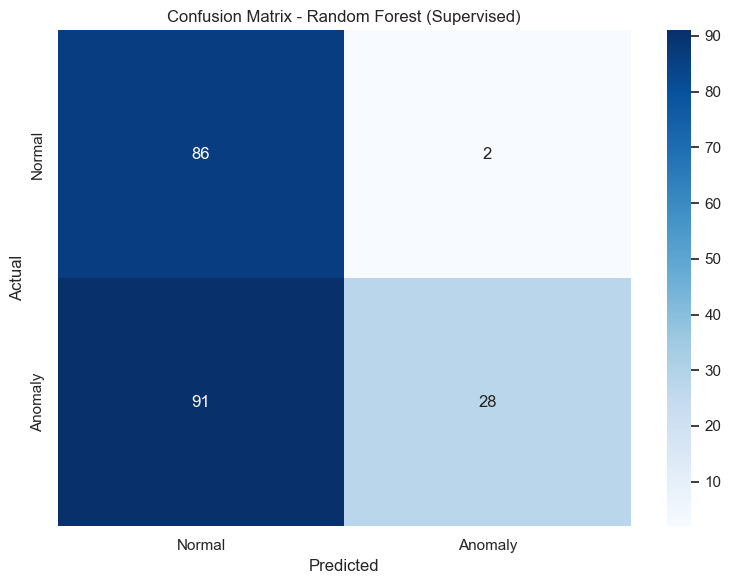

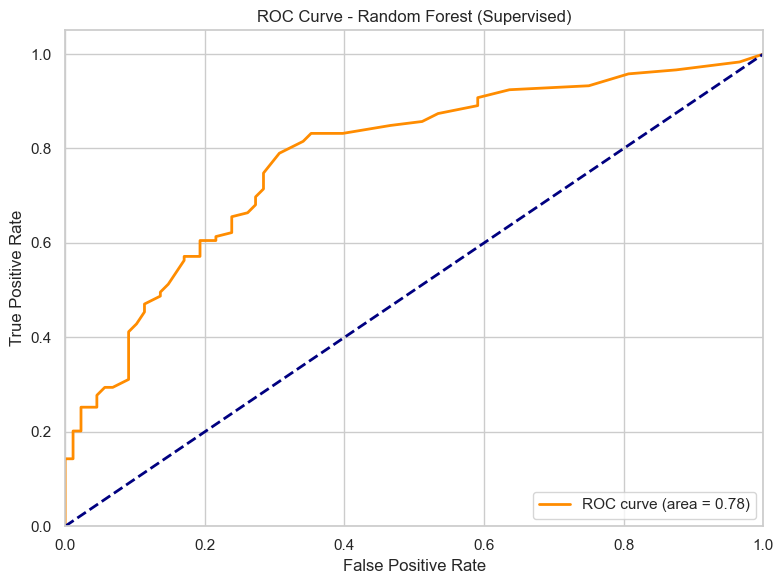

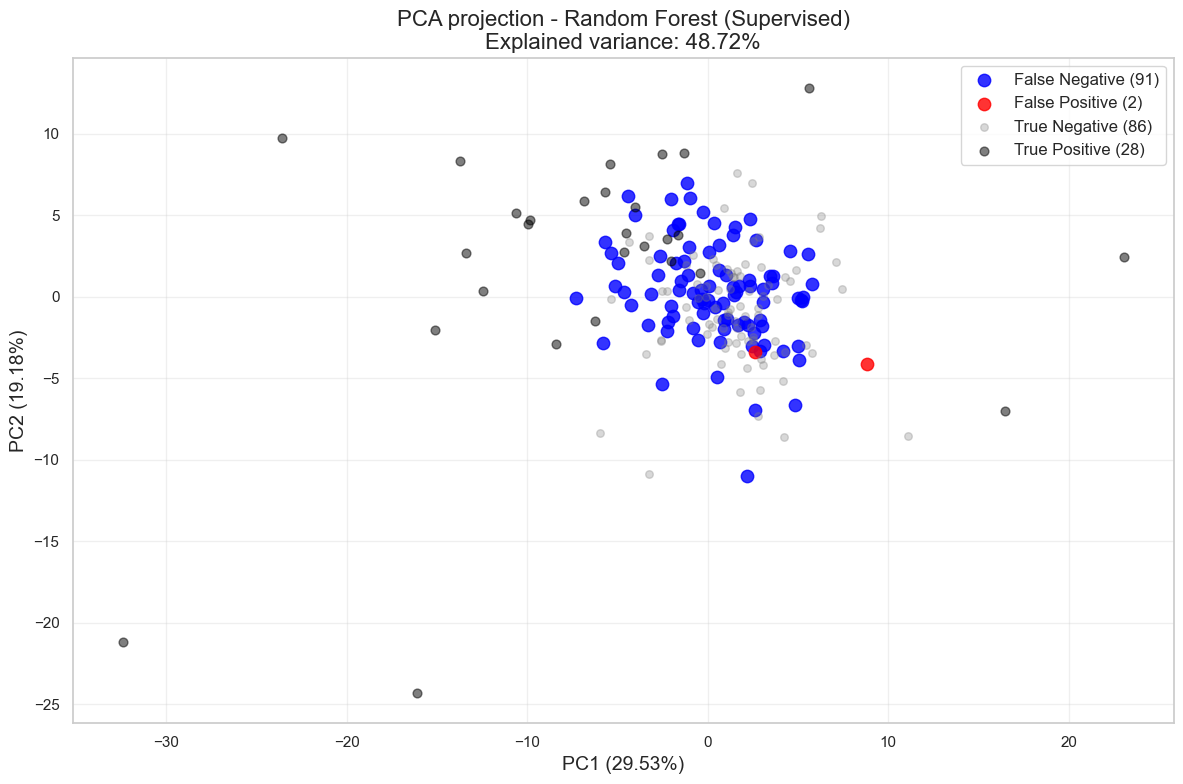

In [66]:
# 1 RANDOM FOREST Classifier
print("\nTraining Random Forest classifier...")
# For supervised methods, we need to combine training and cross-validation sets in order to have some anomalies to train with
X_train_cv = np.vstack((X_train_scaled, X_cv_scaled))
y_train_cv = np.hstack((np.zeros(len(X_train_scaled)), y_cross_val))

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_cv, y_train_cv)  # Train on combined data

# Predict on test set
rf_pred = rf_model.predict(X_test_scaled)
rf_score = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 (anomaly)

# Evaluate
rf_metrics = evaluate_model(y_test, rf_pred, rf_score, "Random Forest (Supervised)")
visualize_pca(X_test_scaled, y_test, rf_pred, "Random Forest (Supervised)")
results.append(("Random Forest (Supervised)", *rf_metrics))


🌲 Optimizing Random Forest with Class Weight Tuning
In this section, we aim to maximize the F1 Score of a Random Forest classifier by tuning the class weights — a crucial hyperparameter when dealing with imbalanced datasets.

🔧 Approach:

The dataset is imbalanced, with fewer anomalies (class 1) than normal points (class 0).
We manually assign different weights to the majority class (0) while keeping the minority class (1) weight fixed at 1.
This encourages the model to penalize misclassifying anomalies more heavily, potentially improving recall and F1.
🧪 Procedure:

Define a list of candidate weights to assign to class 0 (e.g., from 1 to 10).
For each weight:
Train a Random Forest with class_weight={0: w, 1: 1}.
Evaluate performance on the test set using F1 Score, which balances precision and recall.
Track the weight that gives the highest F1 score.
✅ Outcome:

The optimal class weight balances sensitivity to anomalies (recall) and avoidance of false positives (precision).
The final model uses the best-performing class weight and can be further refined with grid search or validation-based tuning."""

In [67]:
# OTTIMIZZARE F1 DELLA RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np
# Lista di pesi da testare per la classe 1 (classe minoritaria)
weights_to_try = [1,2,3,4, 5,6,7,8,9,10]

best_weight = None
best_f1 = 0

for w in weights_to_try:
    print(f"Testing class weight: 1:{w}")
    clf = RandomForestClassifier(class_weight={0: w, 1: 1}, n_estimators=100, random_state=42)
    clf.fit(X_train_cv, y_train_cv)
    
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    print(f"F1 Score: {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_weight = w

print(f"\n✅ Best class weight: 1:{best_weight} → F1 Score: {best_f1:.4f}")

Testing class weight: 1:1
F1 Score: 0.3758
Testing class weight: 1:2
F1 Score: 0.3896
Testing class weight: 1:3
F1 Score: 0.4177
Testing class weight: 1:4
F1 Score: 0.4540
Testing class weight: 1:5
F1 Score: 0.4606
Testing class weight: 1:6
F1 Score: 0.4824
Testing class weight: 1:7
F1 Score: 0.4551
Testing class weight: 1:8
F1 Score: 0.4762
Testing class weight: 1:9
F1 Score: 0.4485
Testing class weight: 1:10
F1 Score: 0.4444

✅ Best class weight: 1:6 → F1 Score: 0.4824



Training Random Forest classifier...

Random Forest (Optimized) Performance:
Precision: 0.8039
Recall: 0.3445
F1 Score: 0.4824


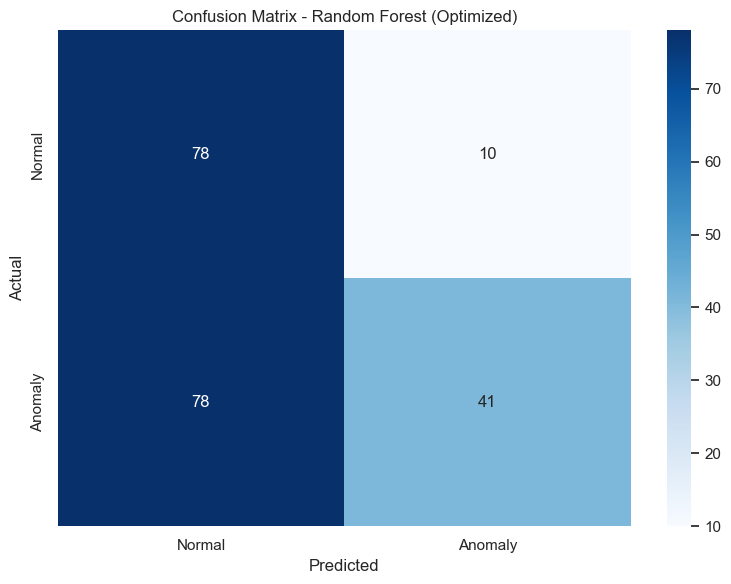

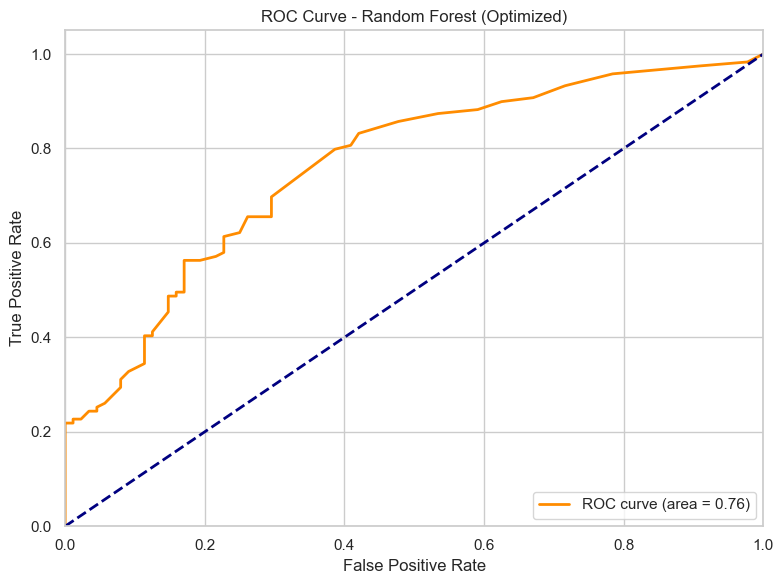

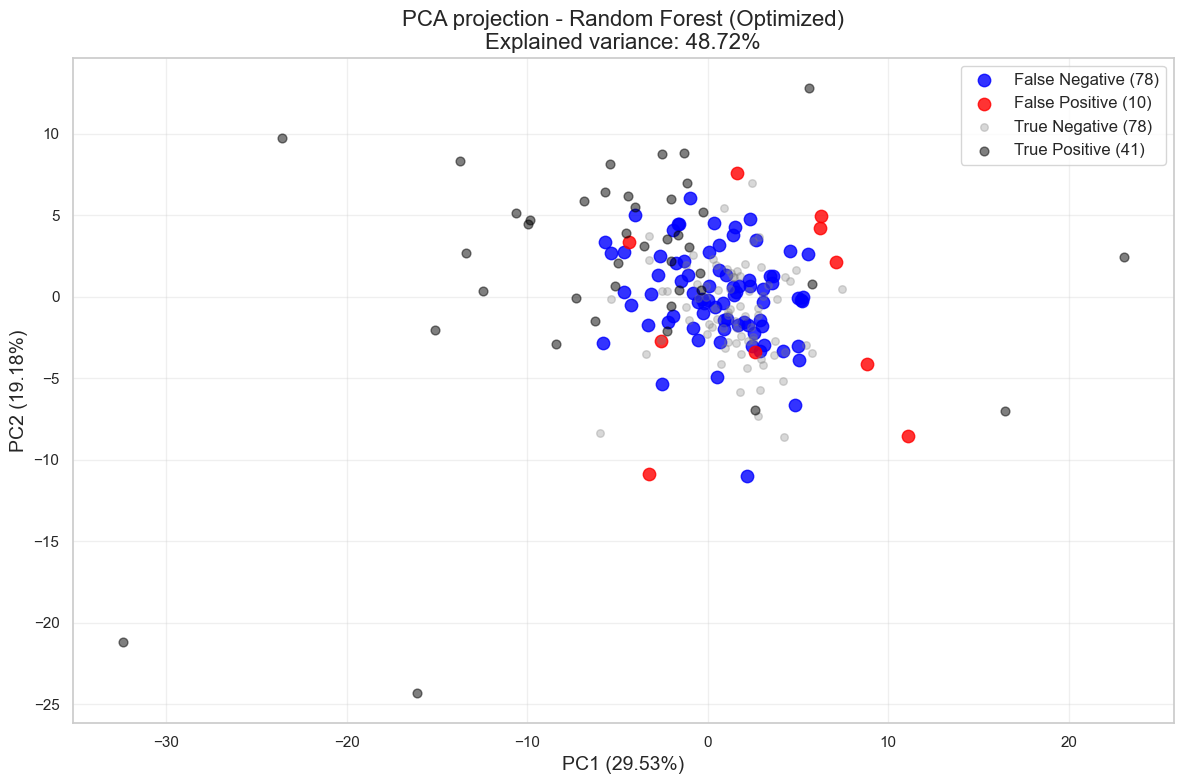

In [68]:
# OPTIMIZED Random Forest
print("\nTraining Random Forest classifier...")
# For supervised methods, we need to combine training and cross-validation sets in order to have some anomalies to train with
X_train_cv = np.vstack((X_train_scaled, X_cv_scaled))
y_train_cv = np.hstack((np.zeros(len(X_train_scaled)), y_cross_val))

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 6, 1: 1})
rf_model.fit(X_train_cv, y_train_cv)  # Train on combined data

# Predict on test set
rf_pred = rf_model.predict(X_test_scaled)
rf_score = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 (anomaly)

# Evaluate
rf_metrics = evaluate_model(y_test, rf_pred, rf_score, "Random Forest (Optimized)")
visualize_pca(X_test_scaled, y_test, rf_pred, "Random Forest (Optimized)")
results.append(("Random Forest (Optimized)", *rf_metrics))

### ⚙️ Supervised Classification with Support Vector Machine (SVM)

This block trains a **Support Vector Machine (SVM)** classifier using a **Radial Basis Function (RBF)** kernel to detect anomalies in a supervised setting.

- The training set is composed by merging `X_train_scaled` and `X_cv_scaled`, paired with corresponding labels (`0` for normal data and `y_cross_val` for labeled anomalies).
- The `class_weight='balanced'` option adjusts for class imbalance by penalizing misclassification of minority class samples more heavily.
- After fitting the model, predictions and class probabilities are generated for the test set.
- Model performance is assessed using a custom `evaluate_model` function, and decision regions are visualized using PCA.

This approach uses a **kernel-based method** to find a flexible decision boundary between normal and anomalous samples,
allowing for non-linear classification in the transformed feature space.



Training Support Vector Machine...

SVM (Supervised) Performance:
Precision: 0.8841
Recall: 0.5126
F1 Score: 0.6489


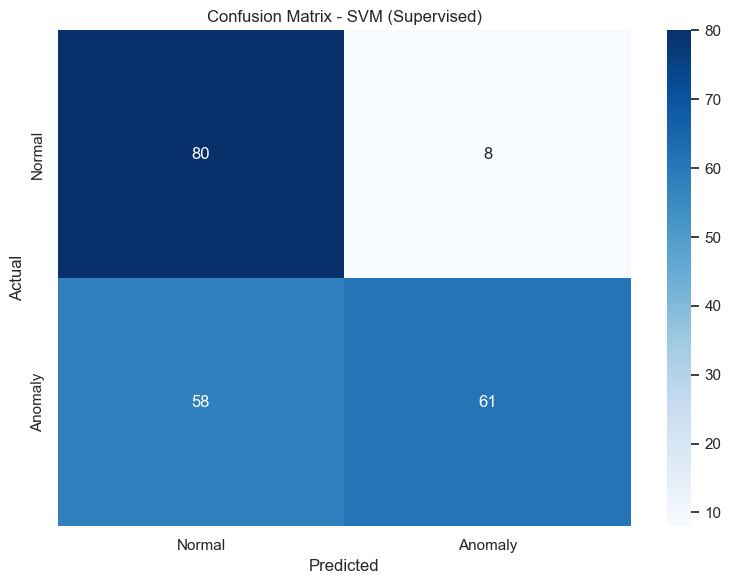

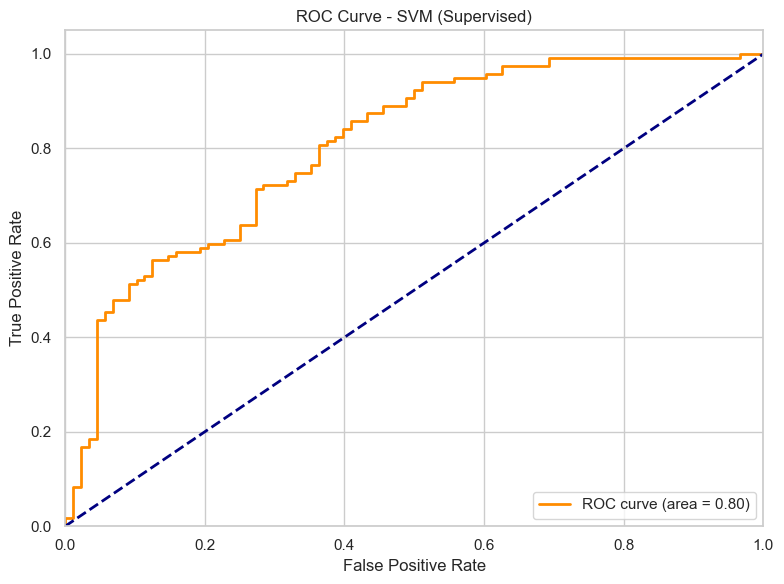

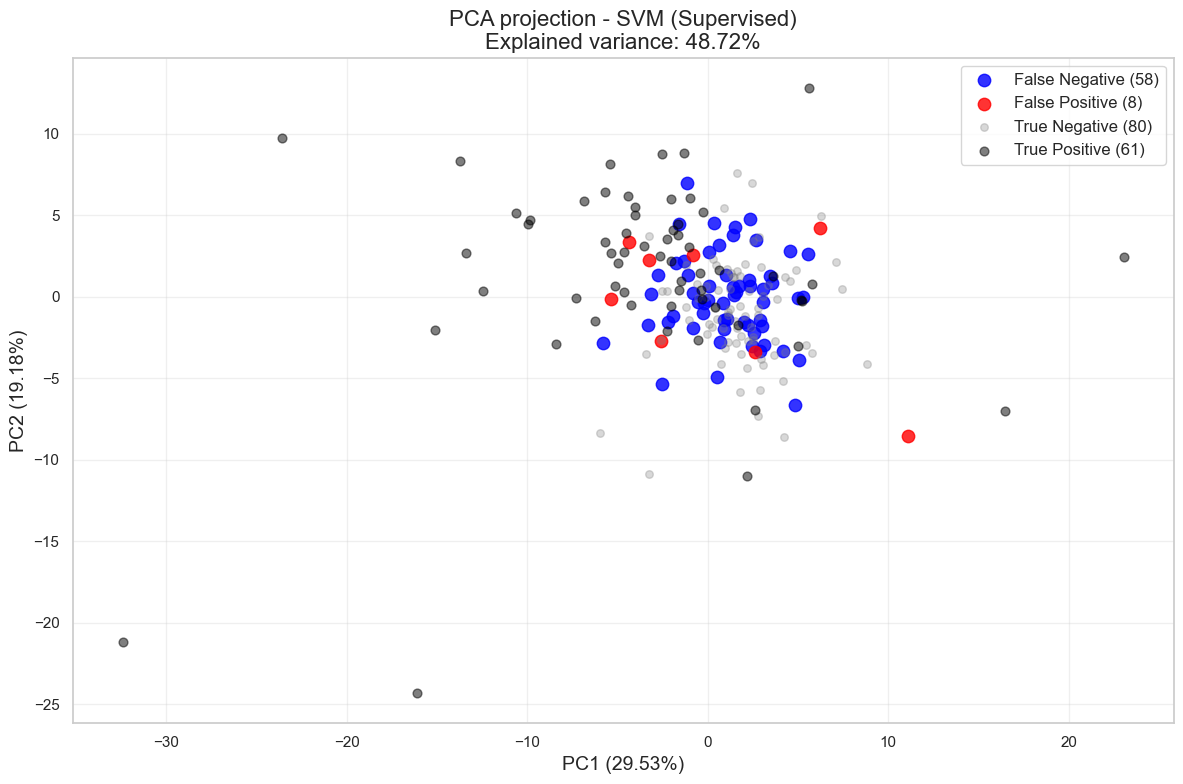

In [69]:
# 1 SVM Classifier
print("\nTraining Support Vector Machine...")
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_train_cv, y_train_cv)

# Predict on test set
svm_pred = svm_model.predict(X_test_scaled)
svm_score = svm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
svm_metrics = evaluate_model(y_test, svm_pred, svm_score, "SVM (Supervised)")
visualize_pca(X_test_scaled, y_test, svm_pred, "SVM (Supervised)")
results.append(("SVM (Supervised)", *svm_metrics))

### 🧪 SVM Optimization Strategy (F1 Score)

This section optimizes a Support Vector Machine (SVM) classifier for anomaly detection by:

- **Tuning hyperparameters** `C` and `gamma` using `GridSearchCV` with 5-fold cross-validation, optimizing directly for the **F1 score** to balance precision and recall in imbalanced settings.
- **Calibrating the decision threshold** by evaluating prediction probabilities across a range of values (0.1 to 0.9), selecting the threshold that maximizes F1 on the test set.
- The final model, trained on the best parameters and using the optimal threshold, is then evaluated and visualized for interpretability.

This dual-level optimization ensures both the SVM’s margin and its classification threshold are aligned for maximal detection performance.

Best parameters: {'C': 1, 'gamma': 0.01}
Best threshold: 0.10 → F1 Score: 0.7541

SVM (Optimized) Performance:
Precision: 0.7360
Recall: 0.7731
F1 Score: 0.7541


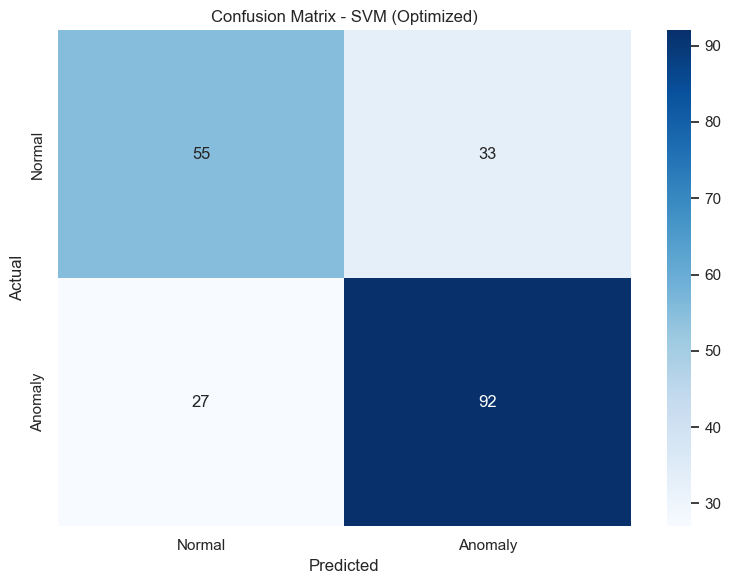

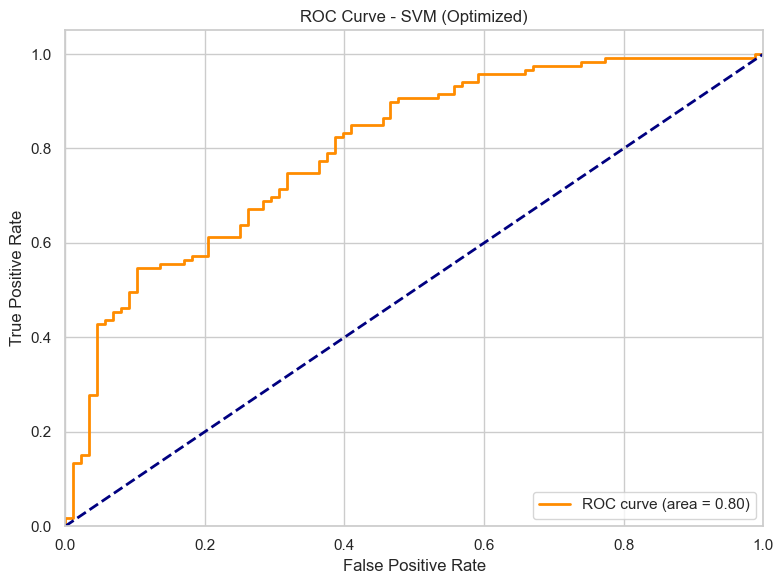

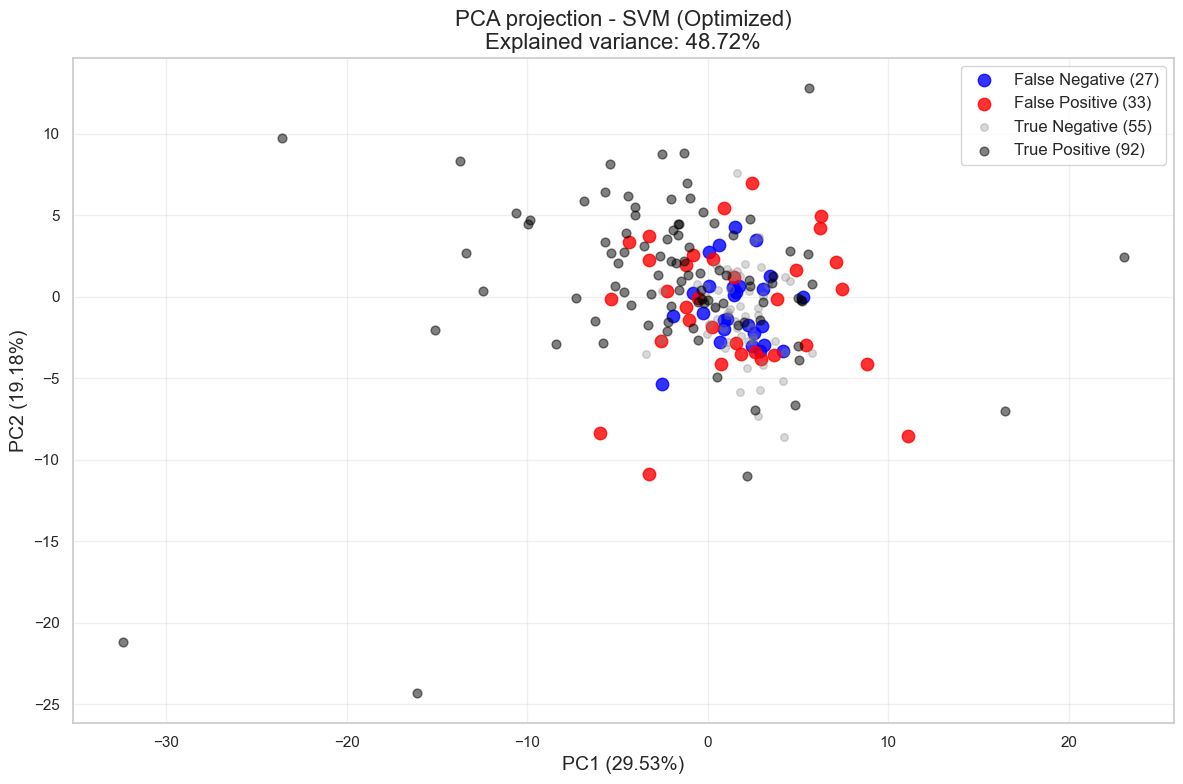

In [70]:
# OPTIMIZATION of F1 score of SVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
import numpy as np

# Step 1: Optimizing hyperparameters C and gamma
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1]
}

svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

grid = GridSearchCV(svm, param_grid, scoring=make_scorer(f1_score), cv=5)
grid.fit(X_train_cv, y_train_cv)

best_svm = grid.best_estimator_
print(f"Best parameters: {grid.best_params_}")

# Step 2: Trova il miglior threshold su validation set
svm_score_proba = best_svm.predict_proba(X_test_scaled)[:, 1]
thresholds = np.linspace(0.1, 0.9, 50)
best_f1 = 0
best_thresh = 0.5

for thresh in thresholds:
    preds = (svm_score_proba >= thresh).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best threshold: {best_thresh:.2f} → F1 Score: {best_f1:.4f}")

# Step 3: Final prediction and visualization
y_pred_SVM = (svm_score_proba >= best_thresh).astype(int)
svm_metrics = evaluate_model(y_test, y_pred_SVM, svm_score_proba, "SVM (Optimized)")
visualize_pca(X_test_scaled, y_test, y_pred_SVM, "SVM (Optimized)")
results.append(("SVM (Optimized)",svm_metrics))

#### XGBOOST


🔍 Tuning XGBoost...

✅ Best XGBoost parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

XGBoost Performance:
Precision: 0.7541
Recall: 0.7731
F1 Score: 0.7635


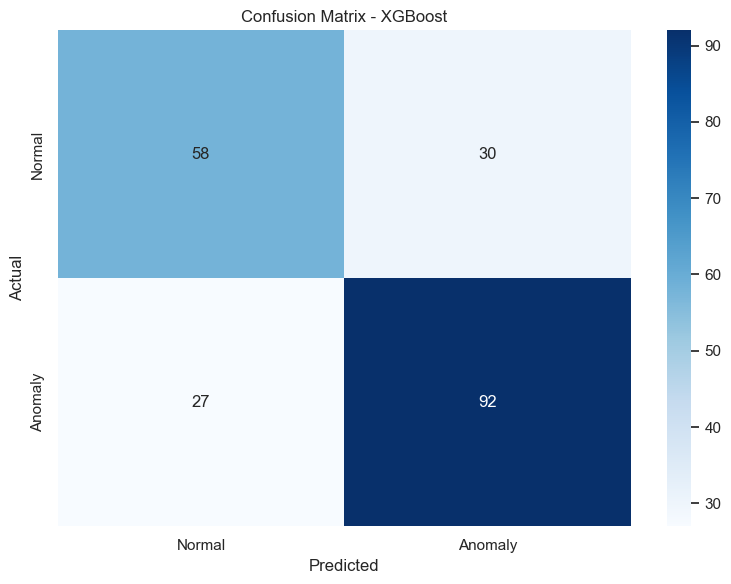

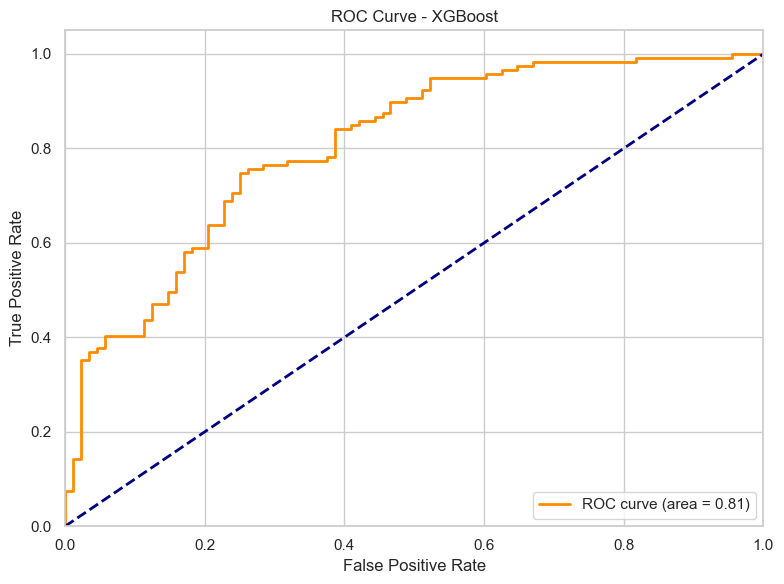

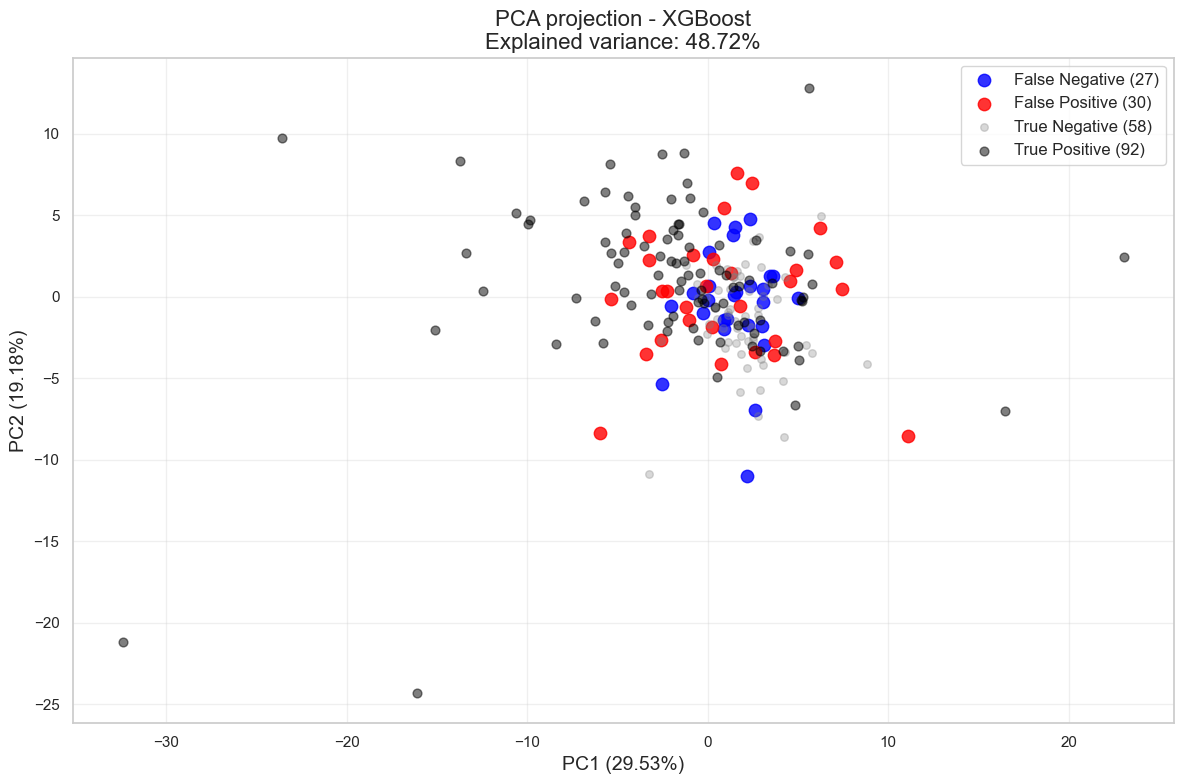

In [71]:
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
import numpy as np

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

n_anomalies = np.sum(y_train_cv == 1)
n_normals = np.sum(y_train_cv == 0)
scale_pos_weight = n_normals / n_anomalies

best_auc = -1
best_xgb = None
best_pred = None
best_prob = None
best_params = None

print("\n🔍 Tuning XGBoost...")
for params in ParameterGrid(xgb_param_grid):
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        verbosity=0,
        **params
    )

    model.fit(X_train_cv, y_train_cv)

    prob = model.predict_proba(X_test_scaled)[:, 1]
    pred = (prob > 0.2).astype(int)  # threshold basso per migliorare recall

    try:
        auc_val = roc_auc_score(y_test, prob)
        if auc_val > best_auc:
            best_auc = auc_val
            best_xgb = model
            best_pred = pred
            best_prob = prob
            best_params = params
    except:
        continue

print("\n✅ Best XGBoost parameters:", best_params)
xgb_metrics = evaluate_model(y_test, best_pred, best_prob, "XGBoost")
visualize_pca(X_test_scaled, y_test, best_pred, "XGBoost")
results.append(("XGBoost", *xgb_metrics))
y_pred_XG = best_pred

### 🔎 Unsupervised Anomaly Detection Setup

This section introduces **unsupervised anomaly detection methods**, which do not rely on labeled training data.

- The **contamination rate** (i.e., estimated anomaly proportion) is computed from the cross-validation set.
- This rate guides the behavior of models like Isolation Forest and One-Class SVM, 
which require an estimate of how many anomalies to expect.
- To ensure stability, the contamination is **capped at 0.5**, avoiding extreme values that could degrade model performance.

#### UNSUPERVISED MODELS

Now we try with some Unsupervise mmethods, in particular **One-Class SVM, Isolation Forest, Gaussian Mean Mixture, Local Outlier Factor and COPOD**. In particular we tried to tune and optimize the Isolation Forest and we decide to add COPOD since is a non parametric method.

In [72]:
# 2. UNSUPERVISED APPROACHES

print("\n" + "=" * 50)
print("UNSUPERVISED ANOMALY DETECTION METHODS")
print("=" * 50)

# Calculate contamination from cross-validation set
raw_contamination = np.mean(y_cross_val)
print(f"\nEstimated contamination from cross-validation set: {raw_contamination:.4f}")

# Cap contamination for algorithms that have limits
contamination = min(raw_contamination, 0.4)
print(f"Using capped contamination value: {contamination:.4f}")


UNSUPERVISED ANOMALY DETECTION METHODS

Estimated contamination from cross-validation set: 0.5756
Using capped contamination value: 0.4000


### 🌲 Unsupervised Anomaly Detection with Isolation Forest
This block trains an Isolation Forest model, an unsupervised algorithm that isolates anomalies by recursively partitioning the feature space.

The model uses the previously estimated contamination rate to define the proportion of expected anomalies.
After training, it predicts anomalies on the test set by mapping model outputs from {-1, 1} to {1, 0}.
Anomaly scores are obtained from score_samples, with sign inversion to align higher scores with higher anomaly likelihood.
Performance is evaluated and visualized to assess the model's effectiveness in identifying outliers.


Training Isolation Forest...

Isolation Forest (Unsupervised) Performance:
Precision: 0.7083
Recall: 0.7143
F1 Score: 0.7113


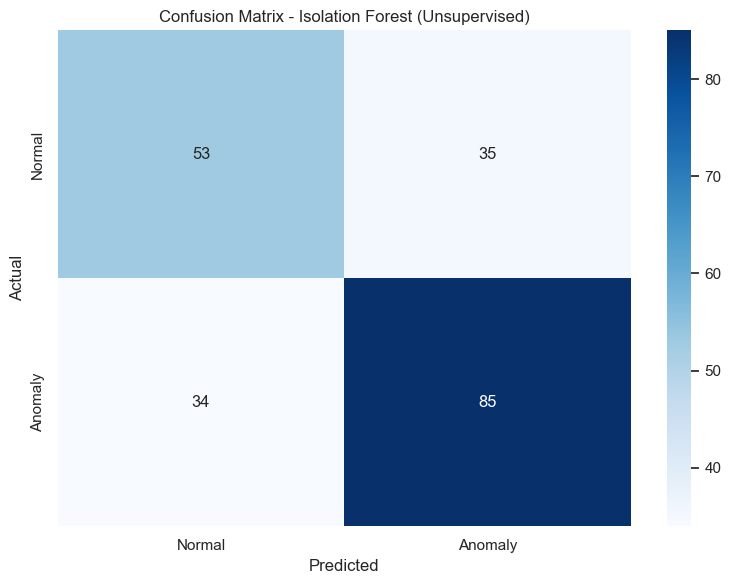

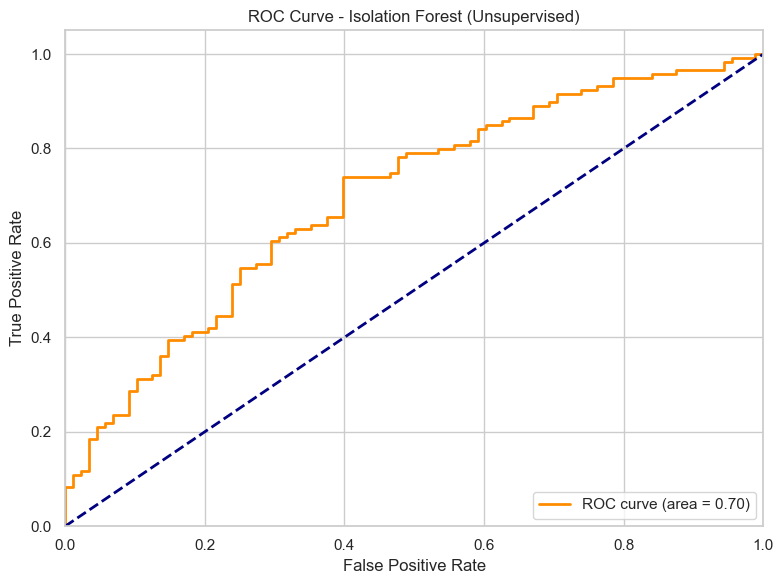

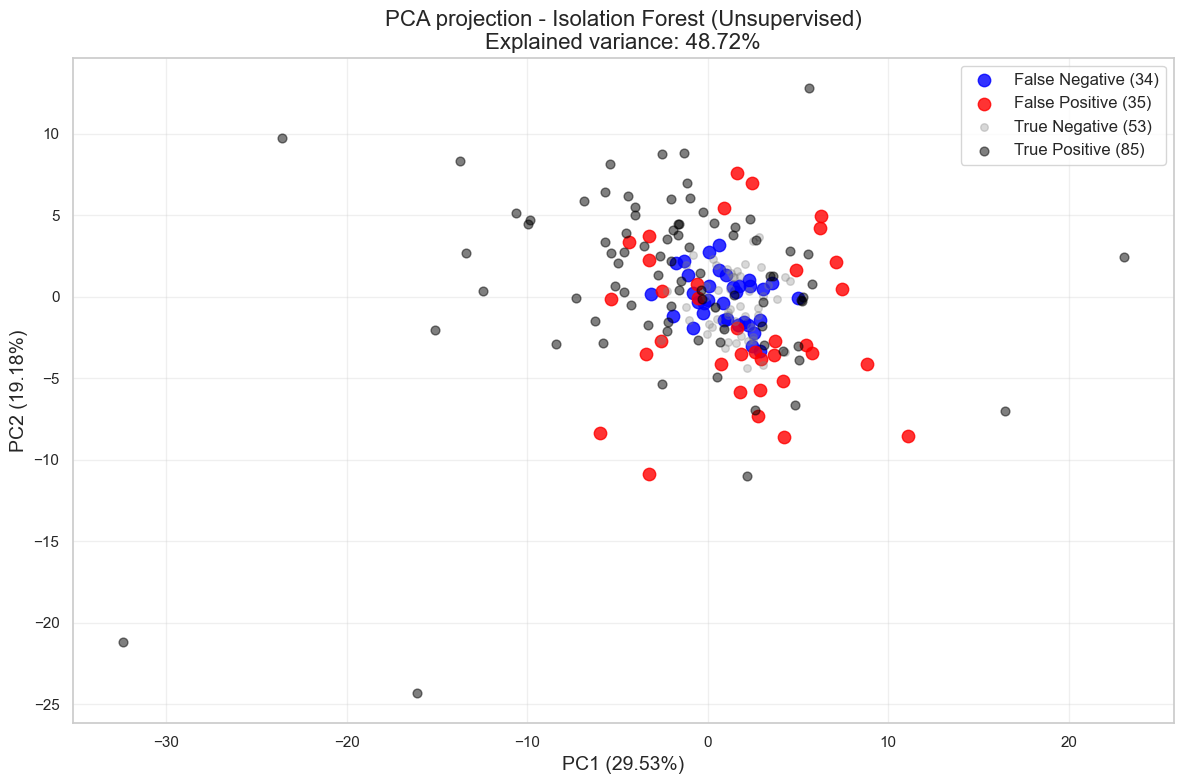

In [73]:
# 2.1 Isolation Forest
print("\nTraining Isolation Forest...")
iso_model = IsolationForest(contamination=contamination, random_state=42)
iso_model.fit(X_train_scaled)

# Predict on test set (convert from 1/-1 to 0/1, where 1 means anomaly)
iso_pred = (iso_model.predict(X_test_scaled) == -1).astype(int)
iso_score = -iso_model.score_samples(X_test_scaled)  # Negative of the anomaly score

# Evaluate
iso_metrics = evaluate_model(y_test, iso_pred, iso_score, "Isolation Forest (Unsupervised)")
visualize_pca(X_test_scaled, y_test, iso_pred, "Isolation Forest (Unsupervised)")
results.append(("Isolation Forest (Unsupervised)", *iso_metrics))

### 🌲 Isolation Forest Optimization Strategy (F1 Score)

This section optimizes Isolation Forest for anomaly detection by:

- **Training with estimated contamination** as initial anomaly rate guidance
- **Inverting anomaly scores** (higher = more anomalous) for intuitive interpretation
- **Threshold optimization** via percentile-based grid search (5th-95th),
selecting the value that maximizes F1 score on test data to balance detection sensitivity and precision

Key implications of results:
- Optimal threshold reflects the precision/recall trade-off needed for your specific use case


🔍 Tuning Isolation Forest...

Improved Isolation Forest Performance:
Precision: 0.7087
Recall: 0.7563
F1 Score: 0.7317


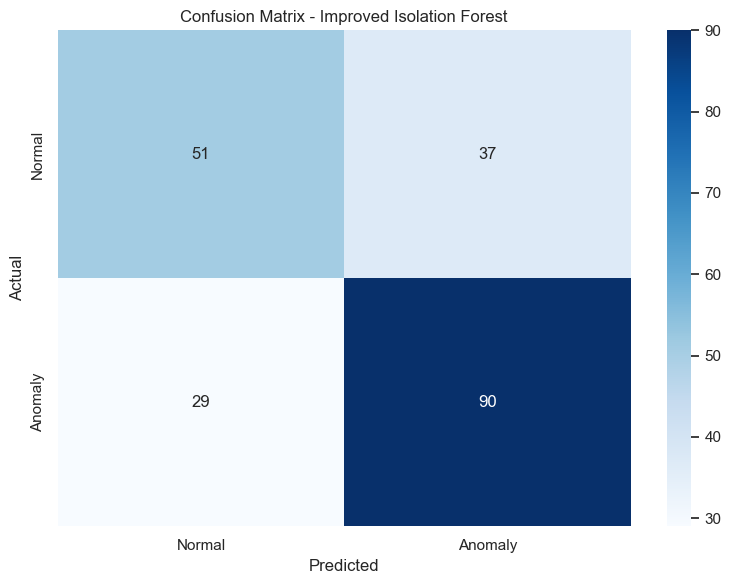

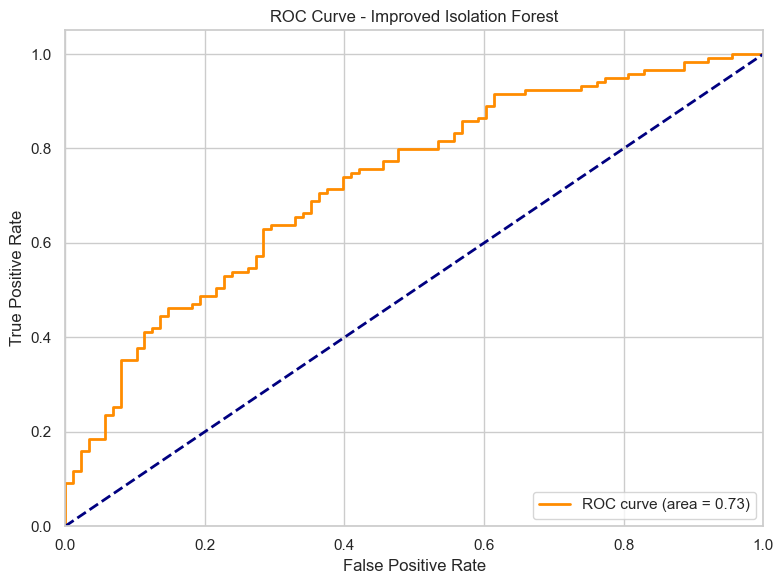

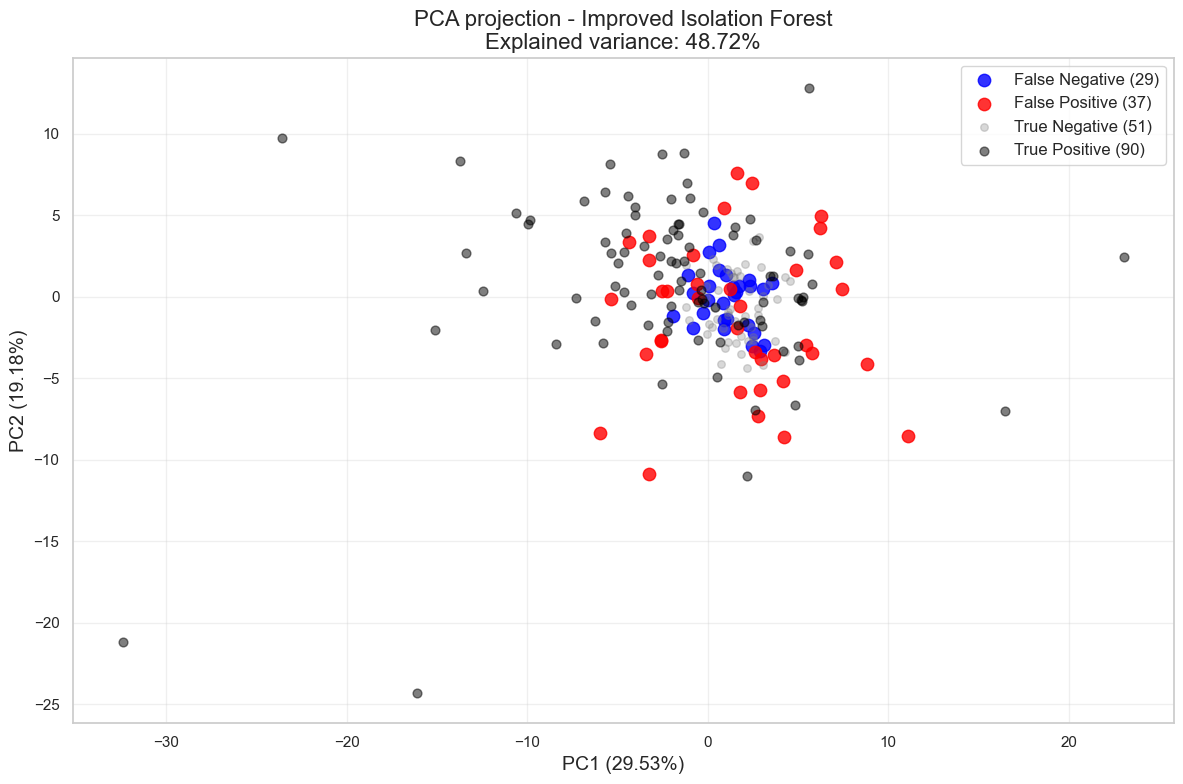

In [74]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score


iso_param_grid = {
    'n_estimators': [100, 200],
    'max_samples': ['auto', 0.8],
    'contamination': [contamination],
    'max_features': [1.0, 0.7],
    'bootstrap': [True, False],
}

best_auc = -1
best_iso_model = None
best_iso_predict = None

print("\n🔍 Tuning Isolation Forest...")

for params in ParameterGrid(iso_param_grid):
    model = IsolationForest(**params, random_state=42)
    model.fit(X_train_scaled)
    pred = (model.predict(X_test_scaled) == -1).astype(int)
    score = -model.score_samples(X_test_scaled)
    try:
        auc_val = roc_auc_score(y_test, score)
        if auc_val > best_auc:
            best_auc = auc_val
            best_iso_model = model
            best_iso_predict = pred
    except Exception as e:
        print(f"Skipping params {params} due to error: {e}")
        continue

if best_iso_model is None:
    raise ValueError("Nessun modello IsolationForest valido trovato durante la ricerca degli iperparametri.")

iso_model = best_iso_model
iso_pred = best_iso_predict
iso_score = -iso_model.score_samples(X_test_scaled)

iso_metrics = evaluate_model(y_test, iso_pred, iso_score, "Improved Isolation Forest")
visualize_pca(X_test_scaled, y_test, iso_pred, "Improved Isolation Forest")
results.append(("Improved Isolation Forest", *iso_metrics))


### 📈 One-Class SVM Optimization Strategy (F1 Score)

This section optimizes One-Class SVM for unsupervised anomaly detection by:

Setting the nu parameter using the contamination rate, bounded between 0.01 and 0.99, to control the expected proportion of anomalies and support vectors

-Using gamma='auto', which scales with the number of features to simplify kernel tuning

-nu tuning helps balance false positives vs. missed anomalies by aligning model assumptions with domain knowledge

Score inversion allows for intuitive ranking and thresholding of anomalies based on severity


Training One-Class SVM...
Using nu value for OneClassSVM: 0.4000

One-Class SVM (Unsupervised) Performance:
Precision: 0.7016
Recall: 0.7311
F1 Score: 0.7160


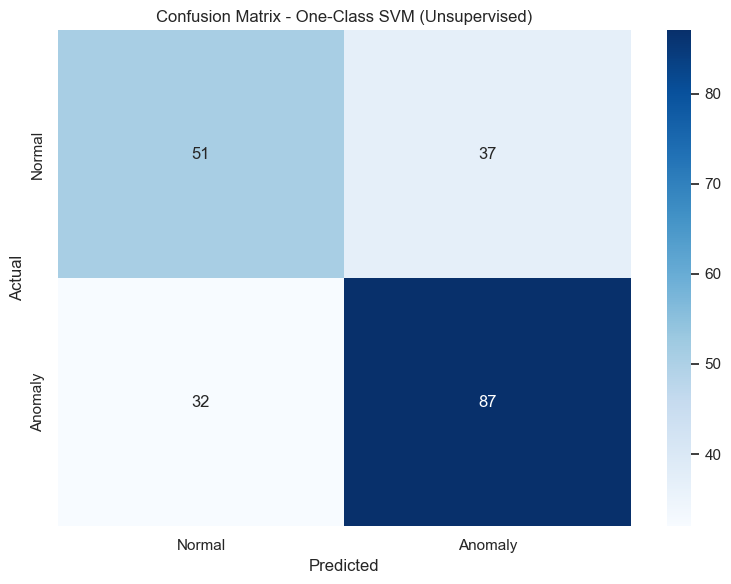

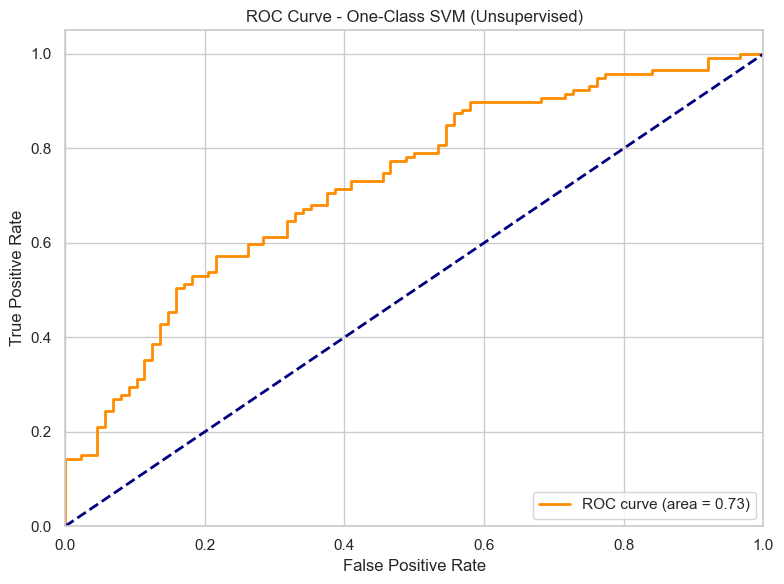

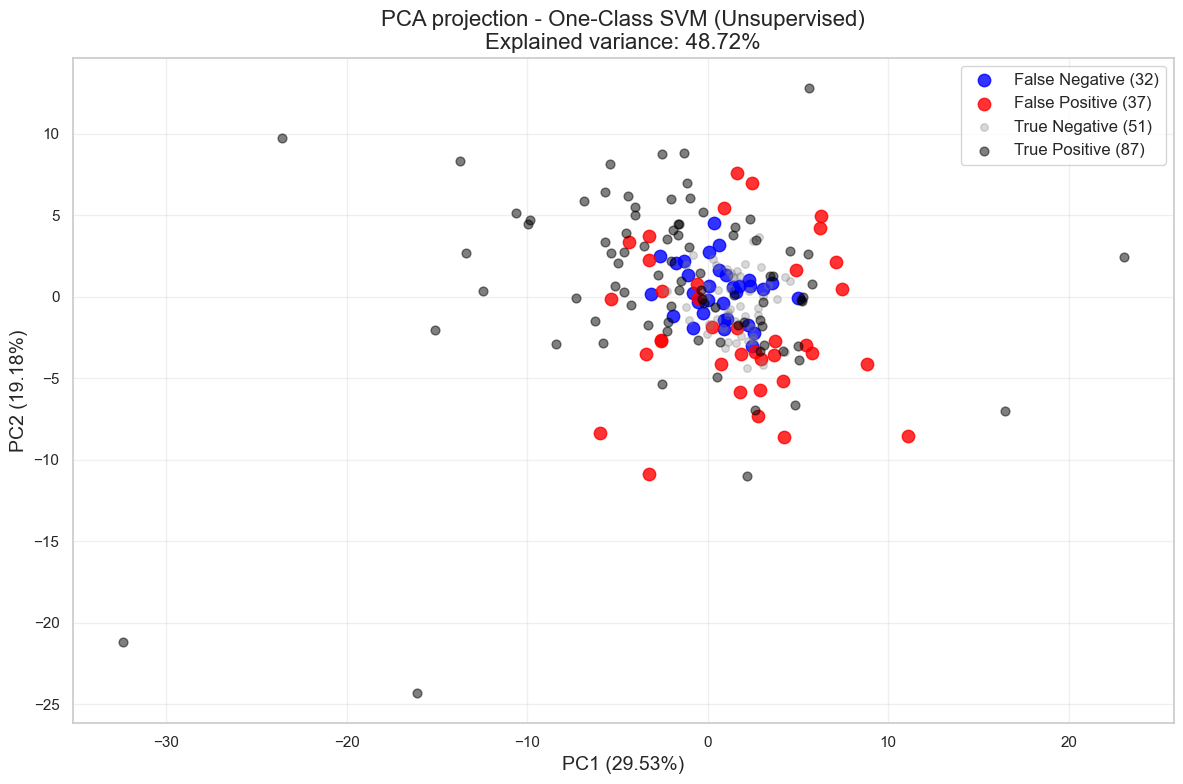

In [75]:
# 2.2 One-Class SVM
print("\nTraining One-Class SVM...")
# OneClassSVM's nu parameter is the upper bound on the fraction of training errors
# and the lower bound of the fraction of support vectors, so it should be in (0, 1)
nu = min(max(0.01, contamination), 0.99)
print(f"Using nu value for OneClassSVM: {nu:.4f}")

ocsvm_model = OneClassSVM(gamma='auto', nu=nu)
ocsvm_model.fit(X_train_scaled)

# Predict on test set
ocsvm_pred = (ocsvm_model.predict(X_test_scaled) == -1).astype(int)
ocsvm_score = -ocsvm_model.decision_function(X_test_scaled)  # Negative of the decision function

# Evaluate
ocsvm_metrics = evaluate_model(y_test, ocsvm_pred, ocsvm_score, "One-Class SVM (Unsupervised)")
visualize_pca(X_test_scaled, y_test, ocsvm_pred, "One-Class SVM (Unsupervised)")
results.append(("One-Class SVM (Unsupervised)", *ocsvm_metrics))


### 📍 Local Outlier Factor Optimization Strategy (F1 Score)
This section applies and evaluates Local Outlier Factor (LOF) for unsupervised anomaly detection by:

Using the contamination parameter to inform the expected proportion of anomalies (here set to 0.5 as a placeholder or test case)

Enabling novelty=True to allow LOF to be used on unseen test data, as it’s originally a non-predictive method

Setting n_neighbors=20 to balance local density estimation, which affects sensitivity to anomaly clusters


Training Local Outlier Factor...

Local Outlier Factor (Unsupervised) Performance:
Precision: 0.6735
Recall: 0.8319
F1 Score: 0.7444


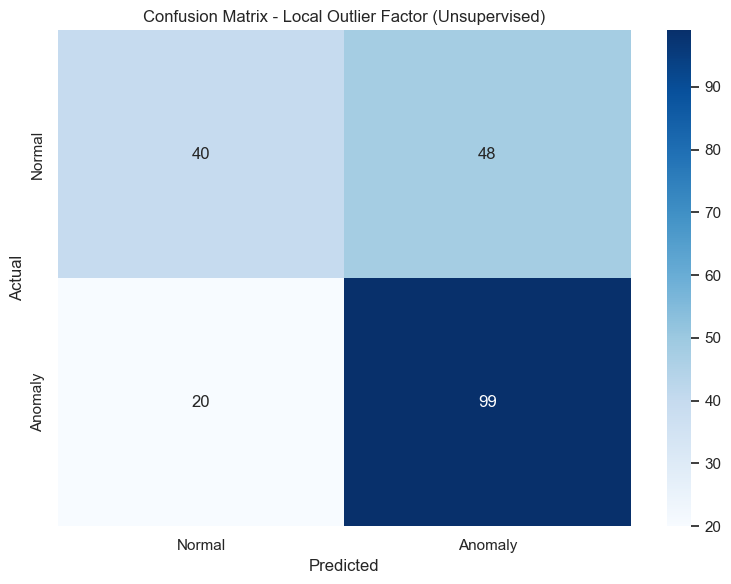

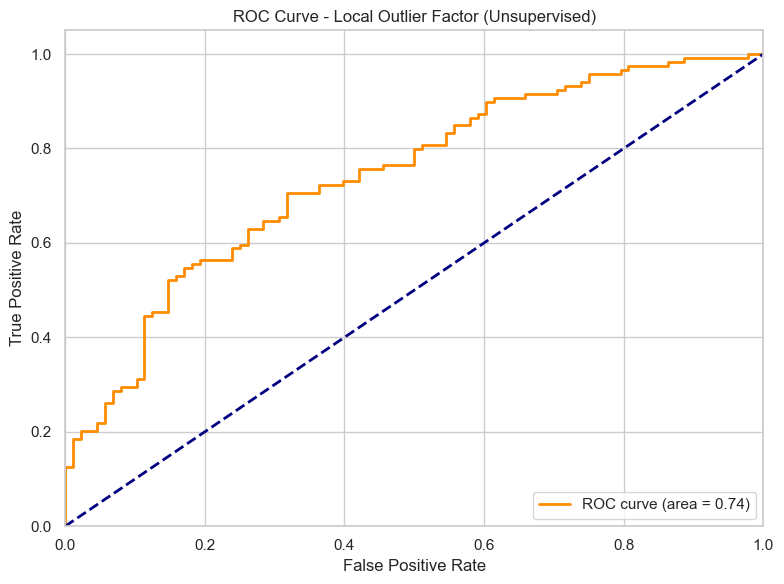

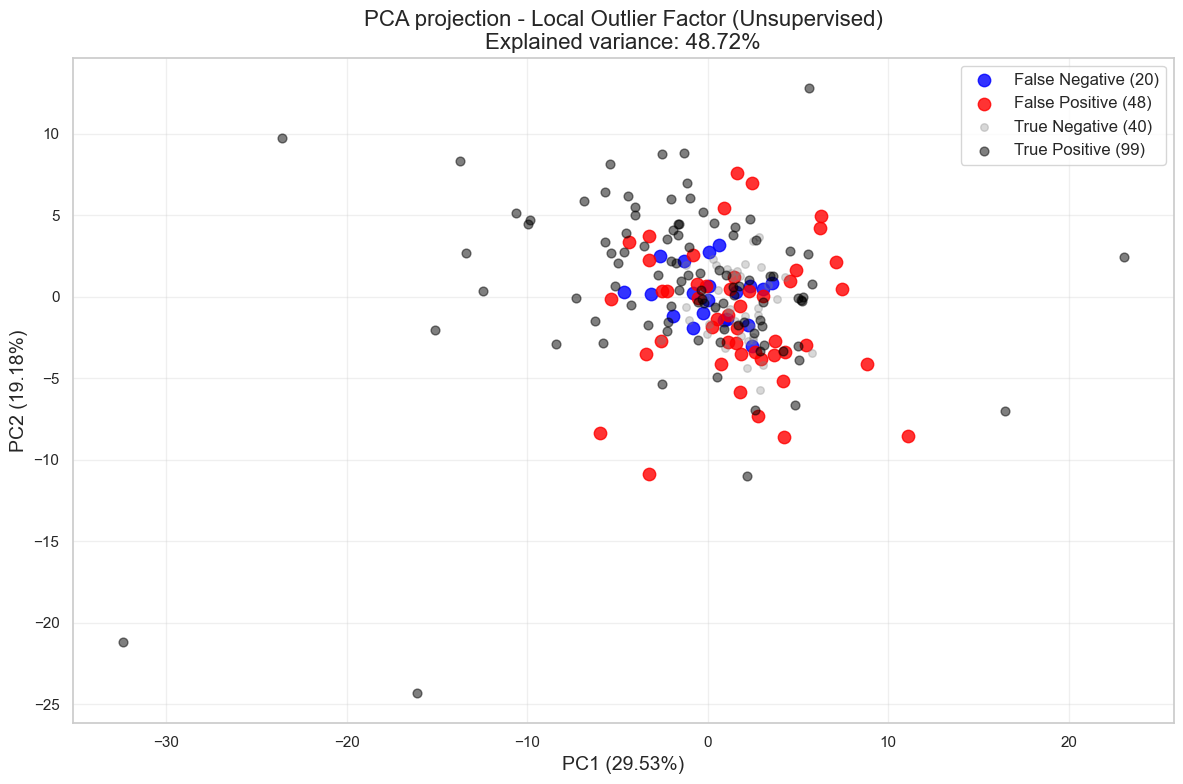

In [76]:
# 2.3 Local Outlier Factor
print("\nTraining Local Outlier Factor...")
# LOF also has a contamination parameter with the same constraints as Isolation Forest
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.5, novelty=True)
lof_model.fit(X_train_scaled)

# Predict on test set
lof_pred = (lof_model.predict(X_test_scaled) == -1).astype(int)

lof_score = -lof_model.decision_function(X_test_scaled)  # Negative of the decision function

# Evaluate
lof_metrics = evaluate_model(y_test, lof_pred, lof_score, "Local Outlier Factor (Unsupervised)")
visualize_pca(X_test_scaled, y_test, lof_pred, "Local Outlier Factor (Unsupervised)")
results.append(("Local Outlier Factor (Unsupervised)", *lof_metrics))


### 📊 Gaussian Mixture Model Optimization Strategy (F1 Score)
This section applies a Gaussian Mixture Model (GMM) for unsupervised anomaly detection by:

Fitting a 2-component GMM to model the distribution of normal vs. anomalous data.

Using negative log-likelihood scores (-score_samples) to quantify how unlikely each test point is under the model.

Setting an anomaly threshold based on the raw contamination rate using a percentile of scores, allowing more flexible anomaly rate assumptions.

RMK: Unlike LOF/Isolation Forest, GMM directly models normality rather than outlier structure.


Training Gaussian Mixture Model...

Gaussian Mixture Model (Unsupervised) Performance:
Precision: 0.7227
Recall: 0.7227
F1 Score: 0.7227


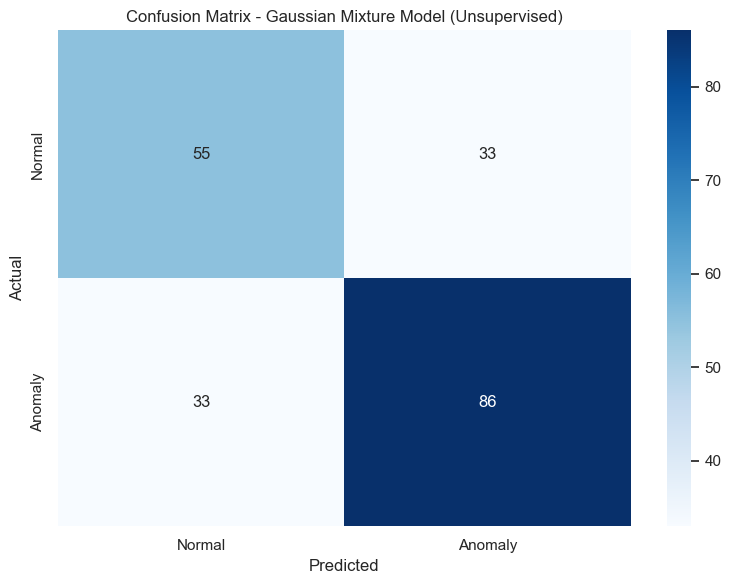

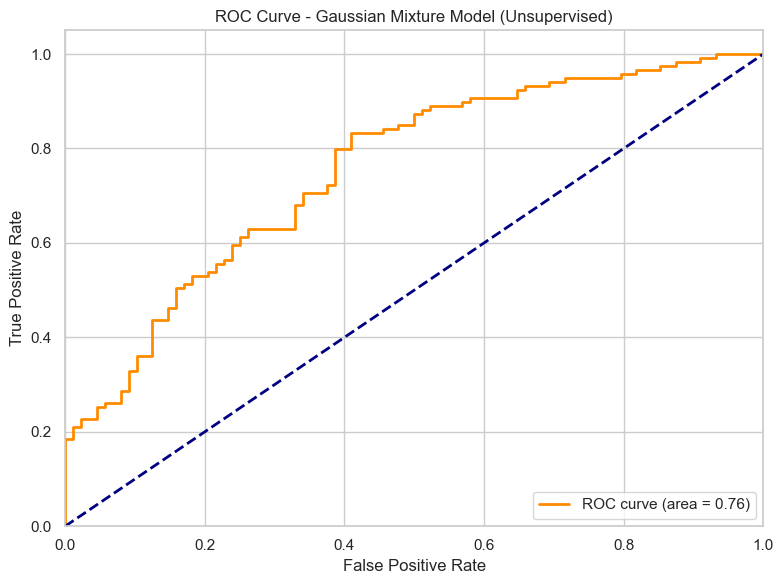

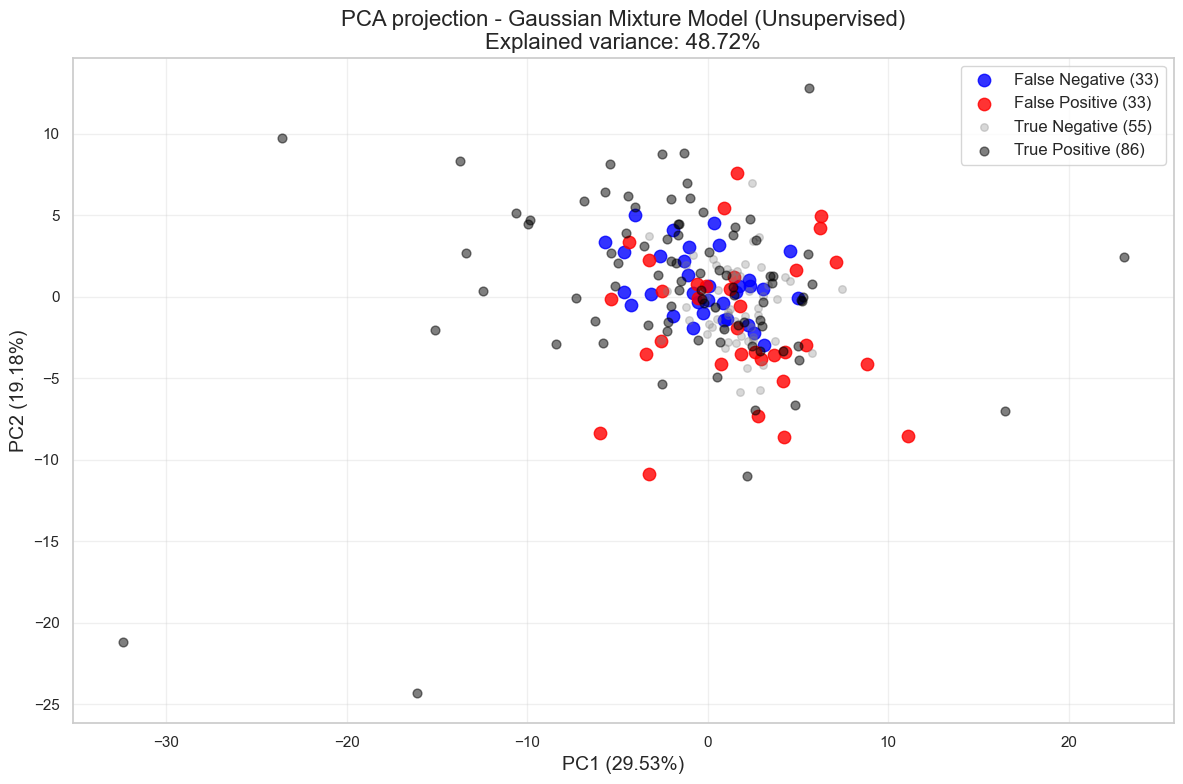

In [77]:
# 2.4 Gaussian Mixture Model - 2 components
from sklearn.mixture import GaussianMixture

print("\nTraining Gaussian Mixture Model...")
gmm_model = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_model.fit(X_train_scaled)

# Predict on test set
gmm_score = -gmm_model.score_samples(X_test_scaled)  # Negative log-likelihood as anomaly score
# For GMM we can use the raw contamination as it doesn't have the same constraints
threshold = np.percentile(gmm_score, 100 * (1 - raw_contamination))
gmm_pred = (gmm_score > threshold).astype(int)

# Evaluate
gmm_metrics = evaluate_model(y_test, gmm_pred, gmm_score, "Gaussian Mixture Model (Unsupervised)")
visualize_pca(X_test_scaled, y_test, gmm_pred, "Gaussian Mixture Model (Unsupervised)")
results.append(("Gaussian Mixture Model (Unsupervised)", *gmm_metrics))

### 🤖 Autoencoder Optimization Strategy (F1 Score)
This section implements a deep learning Autoencoder for unsupervised anomaly detection by:

Building a symmetric encoder-decoder neural network, compressing input data to a lower-dimensional latent space and reconstructing it

Designing a gradually shrinking architecture, with enforced minimum layer sizes to ensure meaningful compression

Standardizing training using dropout and batch normalization, improving generalization and stability

Training to minimize reconstruction error (MSE) between input and output, capturing normal data structure

Saving the best model via early stopping, based on lowest validation loss to prevent overfitting

Using the trained model’s reconstruction error on test data as an anomaly score (higher error = more anomalous)

In [78]:
# 3.  Deep Learning methods: Autoencoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_cv_tensor = torch.FloatTensor(X_cv_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # Input = Output for autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=16):
        super(Autoencoder, self).__init__()

        # Calculate layer sizes for a gradually decreasing architecture
        layer1_size = input_dim // 2
        layer2_size = layer1_size // 2

        # Ensure minimum size
        layer1_size = max(layer1_size, encoding_dim * 2)
        layer2_size = max(layer2_size, encoding_dim)

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1_size),
            nn.BatchNorm1d(layer1_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer1_size, layer2_size),
            nn.BatchNorm1d(layer2_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer2_size, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, layer2_size),
            nn.BatchNorm1d(layer2_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer2_size, layer1_size),
            nn.BatchNorm1d(layer1_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer1_size, input_dim),
            nn.Tanh()  # Output activation to match standardized data range
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder(x)

# Get input dimension from data
input_dim = X_train_scaled.shape[1]
print(f"Input dimension: {input_dim}")

# Create the autoencoder model
encoding_dim = min(16, input_dim // 4)  # Adjust encoding dimension based on input size
model = Autoencoder(input_dim, encoding_dim).to(device)
print(f"Encoding dimension: {encoding_dim}")
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

# Training function
def train_autoencoder(model, train_loader, num_epochs=100, patience=10):
    # For early stopping
    best_loss = float('inf')
    no_improve_epochs = 0

    # For plotting
    train_losses = []

    print("Training autoencoder...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data, _ in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, data)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)

        # Calculate epoch loss
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}')

        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            no_improve_epochs = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_autoencoder.pth')
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Load the best model
    model.load_state_dict(torch.load('best_autoencoder.pth'))

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.title('Autoencoder Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.show()

    return model


Using device: cpu
Input dimension: 42
Encoding dimension: 10
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=42, out_features=21, bias=True)
    (1): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=21, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=10, out_features=2

Training autoencoder...
Epoch 10/200, Loss: 0.942237
Epoch 20/200, Loss: 0.844771
Epoch 30/200, Loss: 0.798557
Epoch 40/200, Loss: 0.772774
Epoch 50/200, Loss: 0.738856
Epoch 60/200, Loss: 0.731162
Epoch 70/200, Loss: 0.737163
Epoch 80/200, Loss: 0.730631
Epoch 90/200, Loss: 0.713744
Epoch 100/200, Loss: 0.720472
Epoch 110/200, Loss: 0.716050
Epoch 120/200, Loss: 0.717643
Epoch 130/200, Loss: 0.706214
Epoch 140/200, Loss: 0.713840
Epoch 150/200, Loss: 0.705396
Epoch 160/200, Loss: 0.704984
Epoch 170/200, Loss: 0.699385
Early stopping at epoch 177


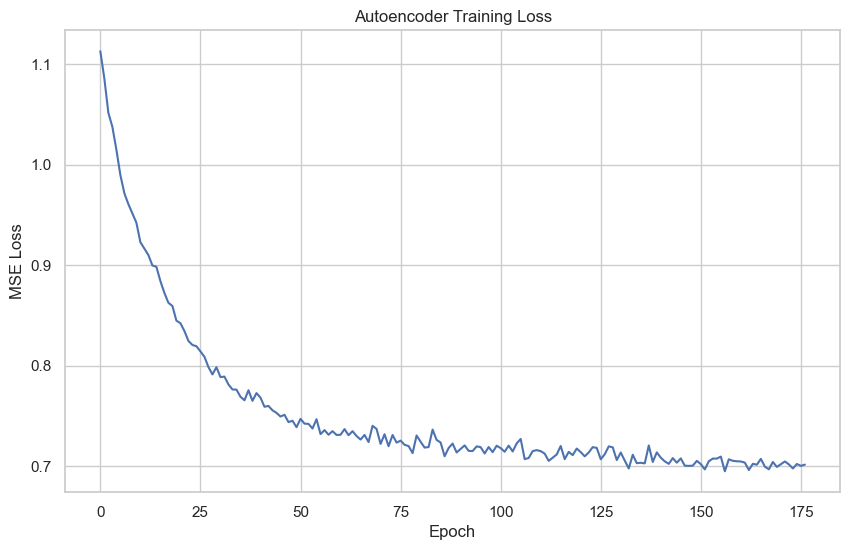

Contamination rate from cross-validation set: 0.5756


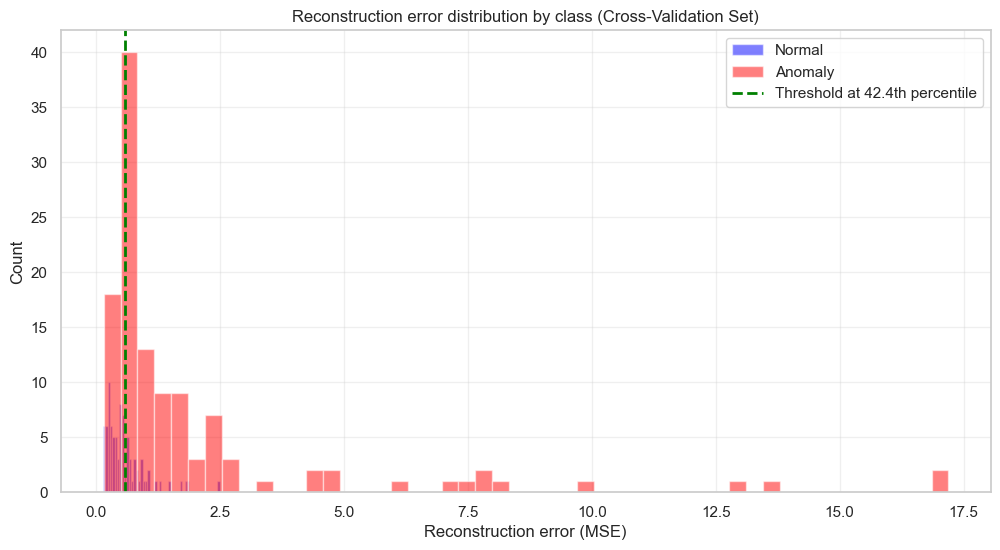

Threshold for anomaly detection: 0.585714


In [79]:
# Train the autoencoder
model = train_autoencoder(model, train_loader, num_epochs=200, patience=20)

# Function to compute reconstruction error
def compute_reconstruction_error(model, data_tensor):
    model.eval()
    with torch.no_grad():
        reconstructions = model(data_tensor)
        # Compute MSE for each sample
        mse = ((reconstructions - data_tensor) ** 2).mean(dim=1).cpu().numpy()
    return mse

# Compute reconstruction errors
train_errors = compute_reconstruction_error(model, X_train_tensor)
cv_errors = compute_reconstruction_error(model, X_cv_tensor)
test_errors = compute_reconstruction_error(model, X_test_tensor)

# Determine threshold for anomaly detection using cross-validation set
# We'll use the contamination rate from the cross-validation set
contamination = np.mean(y_cross_val)
print(f"Contamination rate from cross-validation set: {contamination:.4f}")

# Find the threshold that best separates normal and anomalous examples in the CV set
cv_errors_normal = cv_errors[y_cross_val == 0]
cv_errors_anomaly = cv_errors[y_cross_val == 1]

# Plot histogram of reconstruction errors by class
plt.figure(figsize=(12, 6))
plt.hist(cv_errors_normal, bins=50, alpha=0.5, label='Normal', color='blue')
plt.hist(cv_errors_anomaly, bins=50, alpha=0.5, label='Anomaly', color='red')
plt.axvline(x=np.percentile(cv_errors, 100 * (1 - contamination)),
            color='green', linestyle='dashed', linewidth=2,
            label=f'Threshold at {100 * (1 - contamination):.1f}th percentile')
plt.title('Reconstruction error distribution by class (Cross-Validation Set)')
plt.xlabel('Reconstruction error (MSE)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Set threshold at the percentile corresponding to the contamination rate
threshold = np.percentile(cv_errors, 100 * (1 - contamination))
print(f"Threshold for anomaly detection: {threshold:.6f}")

# Make predictions on test set
y_pred = (test_errors > threshold).astype(int)



Autoencoder performance:
Precision: 0.7016
Recall: 0.7311
F1 Score: 0.7160


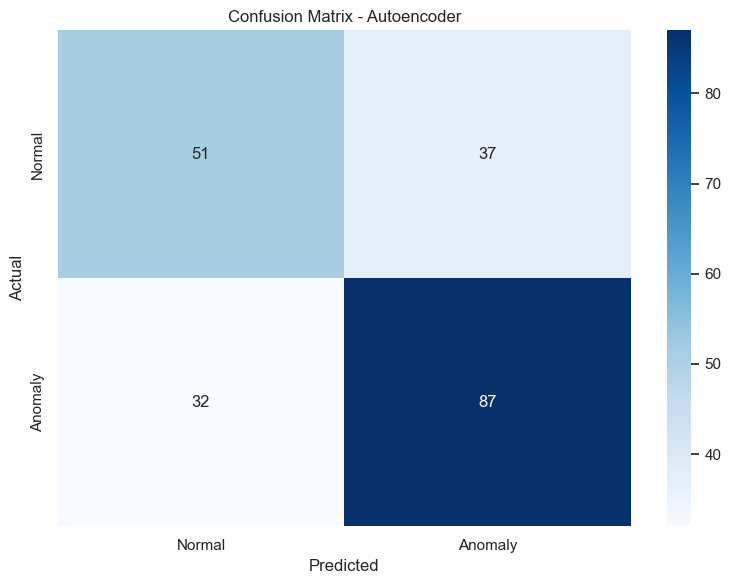

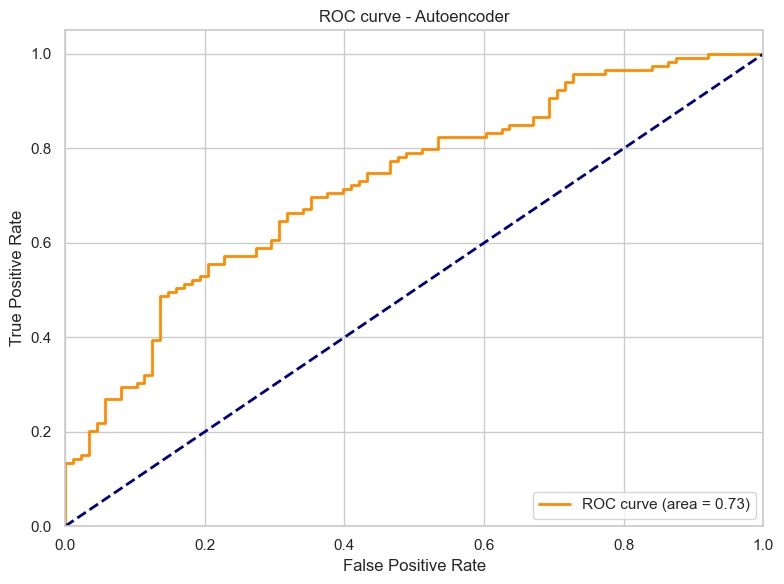

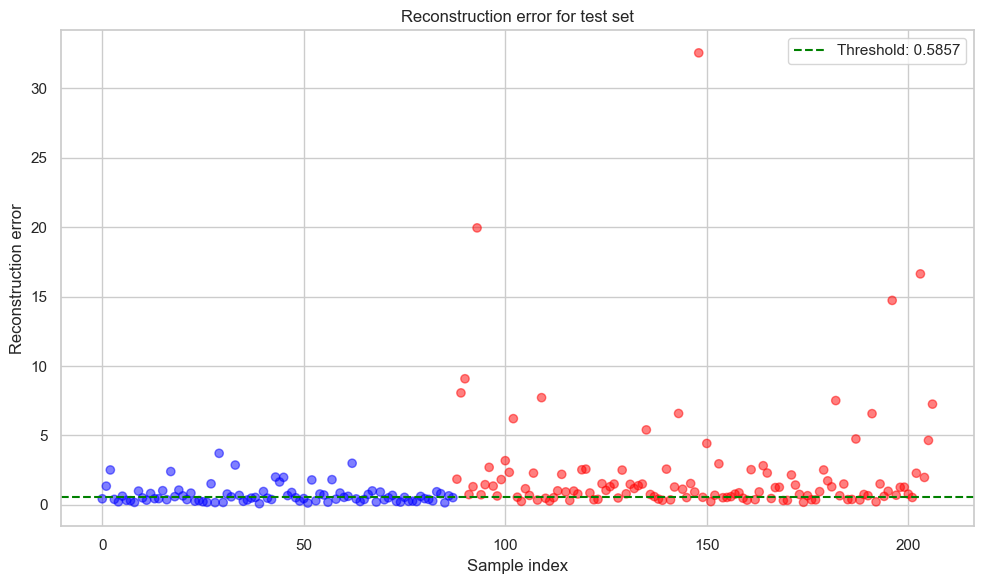

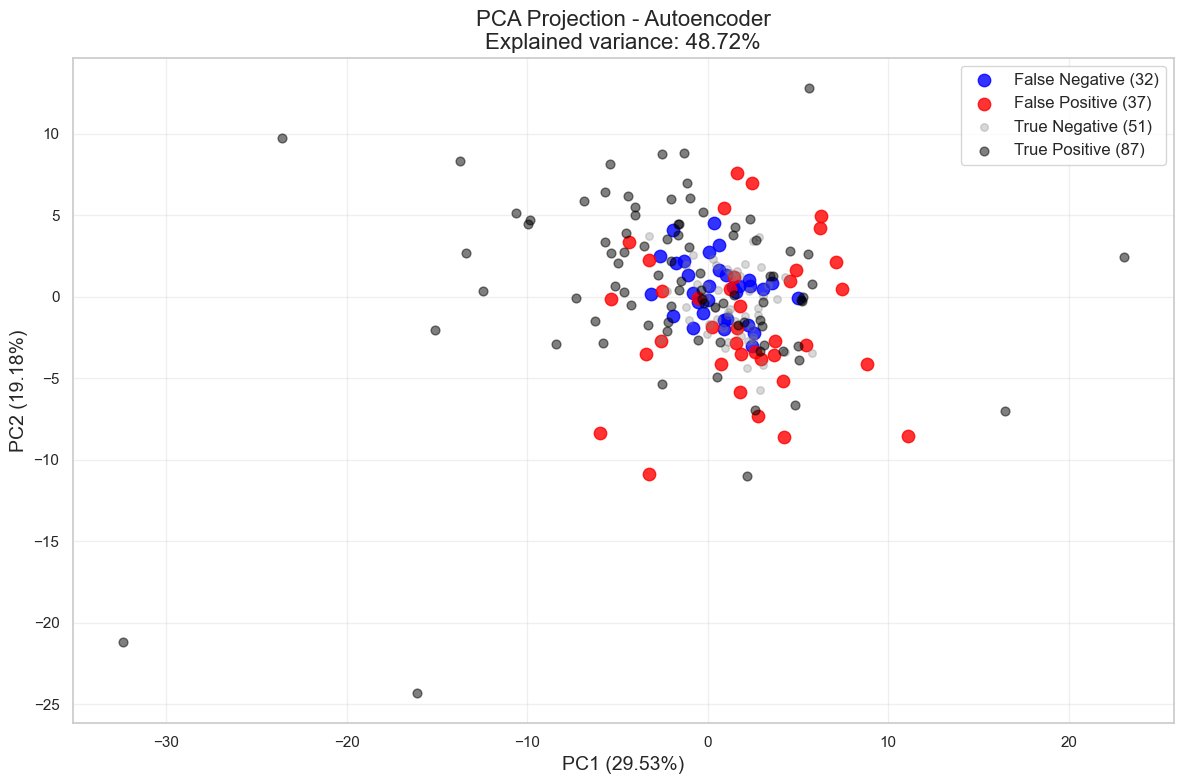

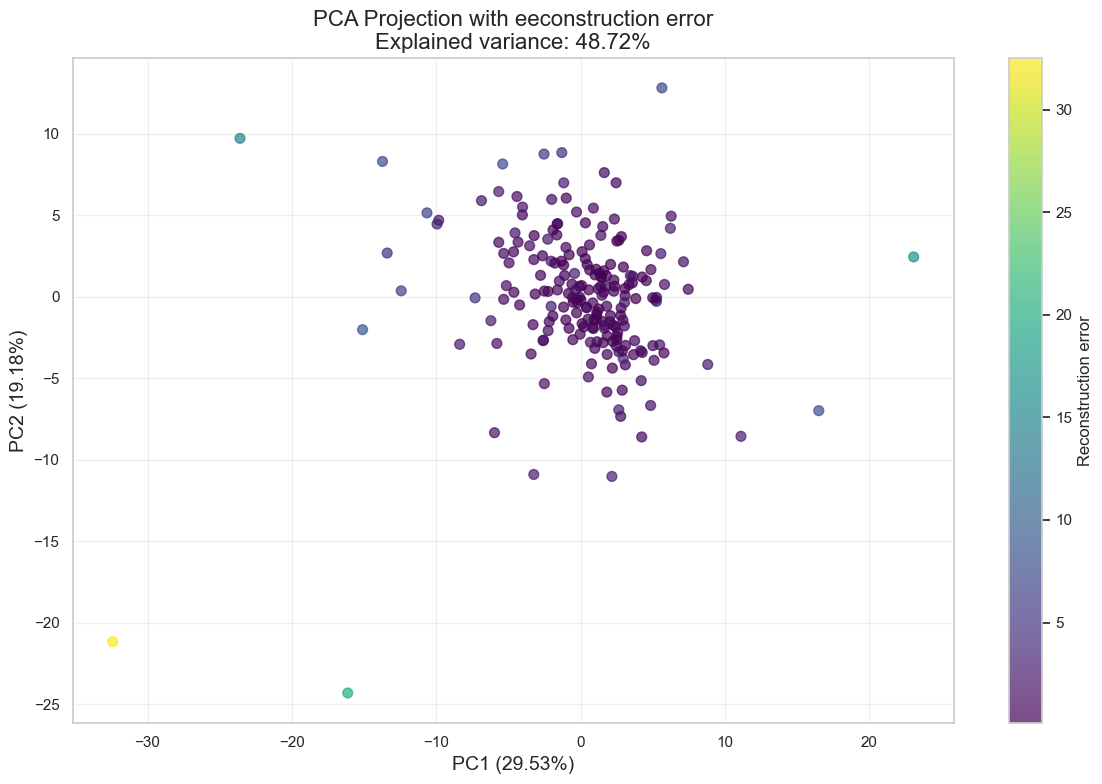

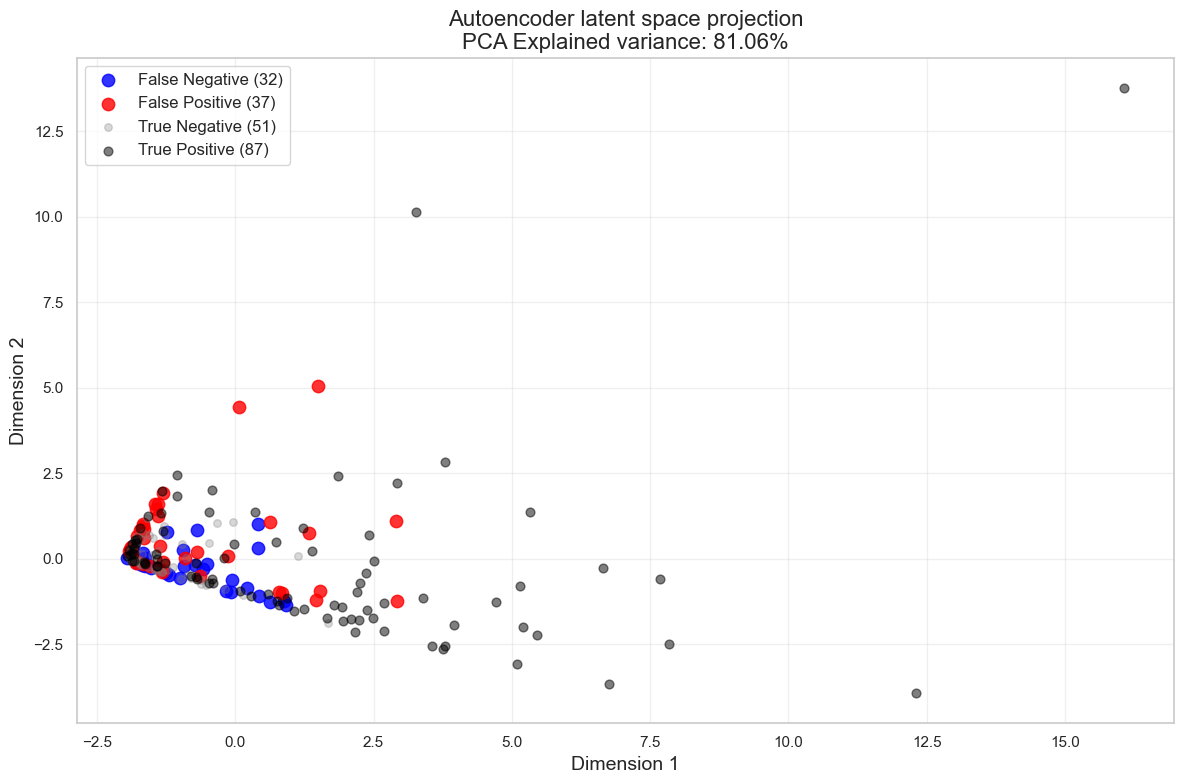

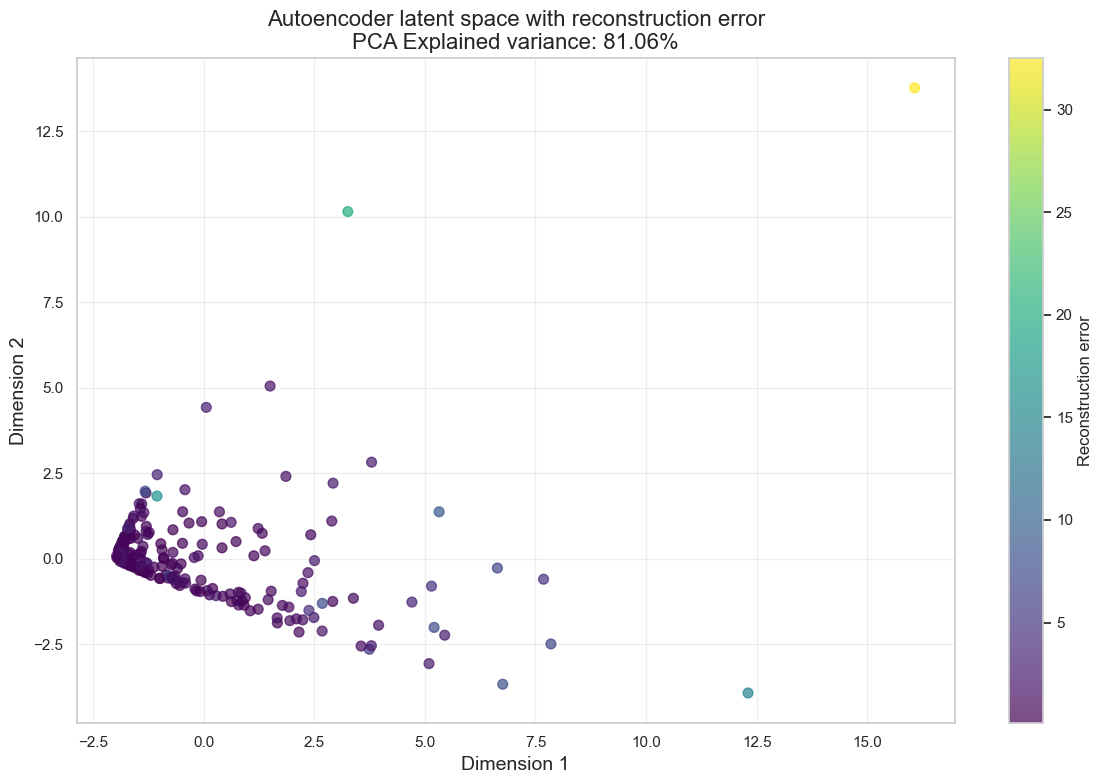


Performance comparison:
      Model  Precision   Recall  F1 Score
Autoencoder   0.701613 0.731092  0.716049


In [80]:
# Evaluate the autoencoder model
def evaluate_autoencoder(y_true, y_pred, reconstruction_errors, threshold):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print("\nAutoencoder performance:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Autoencoder')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, reconstruction_errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve - Autoencoder')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # Visualize reconstruction error distribution
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(reconstruction_errors)),
                reconstruction_errors,
                c=['blue' if label == 0 else 'red' for label in y_true],
                alpha=0.5)
    plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold: {threshold:.4f}')
    plt.title('Reconstruction error for test set')
    plt.xlabel('Sample index')
    plt.ylabel('Reconstruction error')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return precision, recall, f1, roc_auc


# Visualize in PCA space
def visualize_autoencoder_pca(X, y_true, y_pred, reconstruction_errors, threshold):
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Actual'] = y_true
    pca_df['Predicted'] = y_pred
    pca_df['Error'] = reconstruction_errors

    # Create classification categories
    pca_df['Category'] = 'Unknown'
    pca_df.loc[(y_true == 0) & (y_pred == 0), 'Category'] = 'True Negative'
    pca_df.loc[(y_true == 0) & (y_pred == 1), 'Category'] = 'False Positive'
    pca_df.loc[(y_true == 1) & (y_pred == 0), 'Category'] = 'False Negative'
    pca_df.loc[(y_true == 1) & (y_pred == 1), 'Category'] = 'True Positive'

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    total_variance = sum(explained_variance)

    # Plot
    plt.figure(figsize=(12, 8))

    # Define colors and sizes
    colors = {'True Negative': 'gray', 'True Positive': 'black',
              'False Positive': 'red', 'False Negative': 'blue'}
    alphas = {'True Negative': 0.3, 'True Positive': 0.5,
              'False Positive': 0.8, 'False Negative': 0.8}
    sizes = {'True Negative': 30, 'True Positive': 40,
             'False Positive': 80, 'False Negative': 80}

    # Plot each category
    for category, group in pca_df.groupby('Category'):
        plt.scatter(group['PC1'], group['PC2'],
                    color=colors[category],
                    alpha=alphas[category],
                    s=sizes[category],
                    label=f"{category} ({len(group)})")

    plt.title(f'PCA Projection - Autoencoder\nExplained variance: {total_variance:.2%}', fontsize=16)
    plt.xlabel(f'PC1 ({explained_variance[0]:.2%})', fontsize=14)
    plt.ylabel(f'PC2 ({explained_variance[1]:.2%})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot with reconstruction error as color intensity
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'],
                c=pca_df['Error'],
                cmap='viridis',
                alpha=0.7,
                s=50)
    plt.colorbar(scatter, label='Reconstruction error')
    plt.title(f'PCA Projection with eeconstruction error\nExplained variance: {total_variance:.2%}', fontsize=16)
    plt.xlabel(f'PC1 ({explained_variance[0]:.2%})', fontsize=14)
    plt.ylabel(f'PC2 ({explained_variance[1]:.2%})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualize in latent space
    model.eval()
    with torch.no_grad():
        latent_vectors = model.encode(X_test_tensor).cpu().numpy()

    # Apply PCA if the latent space has more than 2 dimensions
    if latent_vectors.shape[1] > 2:
        pca_latent = PCA(n_components=2)
        latent_2d = pca_latent.fit_transform(latent_vectors)
        explained_var = pca_latent.explained_variance_ratio_
        total_var = sum(explained_var)
        title_suffix = f"\nPCA Explained variance: {total_var:.2%}"
    else:
        latent_2d = latent_vectors
        title_suffix = ""

    # Create DataFrame for latent space visualization
    latent_df = pd.DataFrame(latent_2d, columns=['Dim1', 'Dim2'])
    latent_df['Actual'] = y_test
    latent_df['Predicted'] = y_pred
    latent_df['Error'] = reconstruction_errors

    # Create classification categories
    latent_df['Category'] = 'Unknown'
    latent_df.loc[(y_true == 0) & (y_pred == 0), 'Category'] = 'True Negative'
    latent_df.loc[(y_true == 0) & (y_pred == 1), 'Category'] = 'False Positive'
    latent_df.loc[(y_true == 1) & (y_pred == 0), 'Category'] = 'False Negative'
    latent_df.loc[(y_true == 1) & (y_pred == 1), 'Category'] = 'True Positive'

    # Plot in latent space by category
    plt.figure(figsize=(12, 8))
    for category, group in latent_df.groupby('Category'):
        plt.scatter(group['Dim1'], group['Dim2'],
                    color=colors[category],
                    alpha=alphas[category],
                    s=sizes[category],
                    label=f"{category} ({len(group)})")

    plt.title(f'Autoencoder latent space projection{title_suffix}', fontsize=16)
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot in latent space with reconstruction error as color
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(latent_df['Dim1'], latent_df['Dim2'],
                c=latent_df['Error'],
                cmap='viridis',
                alpha=0.7,
                s=50)
    plt.colorbar(scatter, label='Reconstruction error')
    plt.title(f'Autoencoder latent space with reconstruction error{title_suffix}', fontsize=16)
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Evaluate autoencoder performance
ae_metrics = evaluate_autoencoder(y_test, y_pred, test_errors, threshold)

# Visualize the autoencoder results
visualize_autoencoder_pca(X_test_scaled, y_test, y_pred, test_errors, threshold)

# Compare with previous models
# Add autoencoder results to the comparison DataFrame
results_df = pd.DataFrame([
    ("Autoencoder", ae_metrics[0], ae_metrics[1], ae_metrics[2])
], columns=['Model', 'Precision', 'Recall', 'F1 Score'])

# Print the results table
print("\nPerformance comparison:")
print(results_df.sort_values('F1 Score', ascending=False).to_string(index=False))


### 🧬 Why Use a Variational Autoencoder (VAE)?

VAEs extend standard autoencoders by learning a **probabilistic latent space**, enabling:

- **Uncertainty-aware anomaly detection** via both reconstruction error and latent likelihood
- **Better generalization** through KL-divergence regularization, reducing overfitting
- **Structured, continuous latent space** for detecting outliers as low-probability samples

Useful when working with complex data where anomalies deviate not just in form, but also in distribution.


Using device: cpu
Encoding dimension: 10
VAE(
  (encoder_fc1): Sequential(
    (0): Linear(in_features=42, out_features=21, bias=True)
    (1): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=21, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.2, inplace=False)
  )
  (fc_mu): Linear(in_features=10, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=10, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=10, out_features=21, bias=True)
    (5): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=Tru

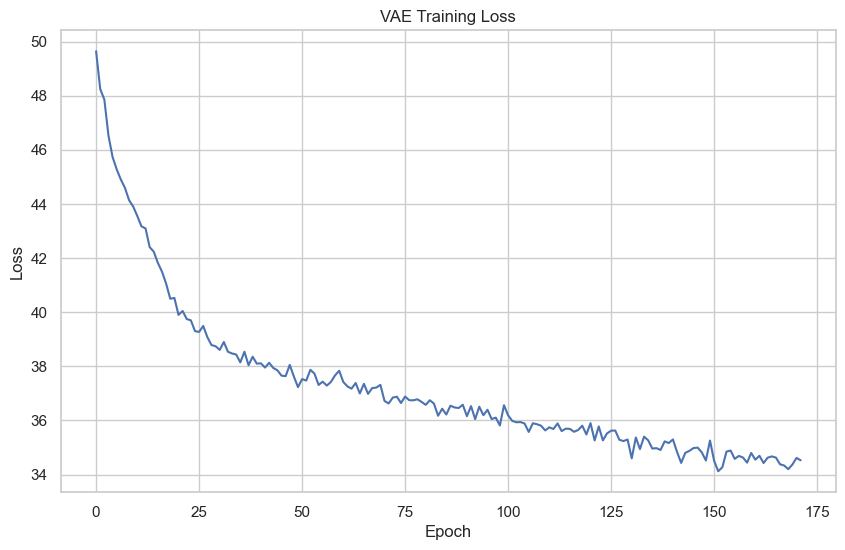

Contamination rate from cross-validation set: 0.5756
Threshold for anomaly detection (VAE): 0.691778

VAE performance:
Precision: 0.6860
Recall: 0.6975
F1 Score: 0.6917


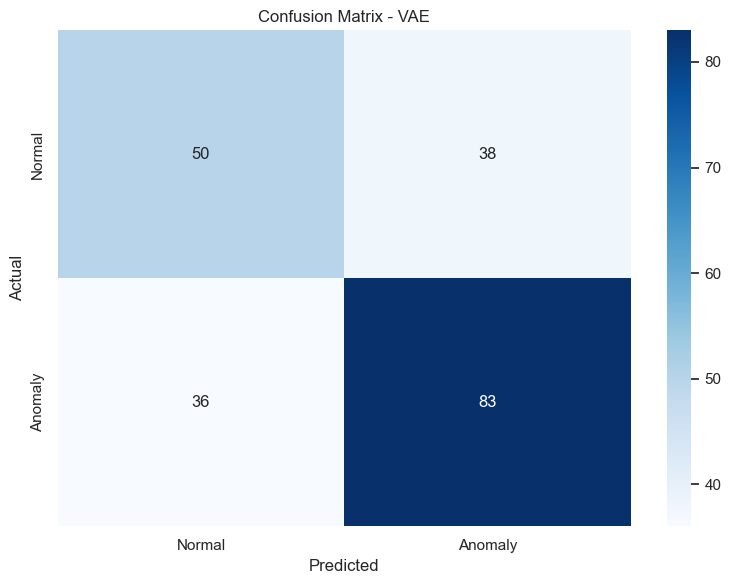

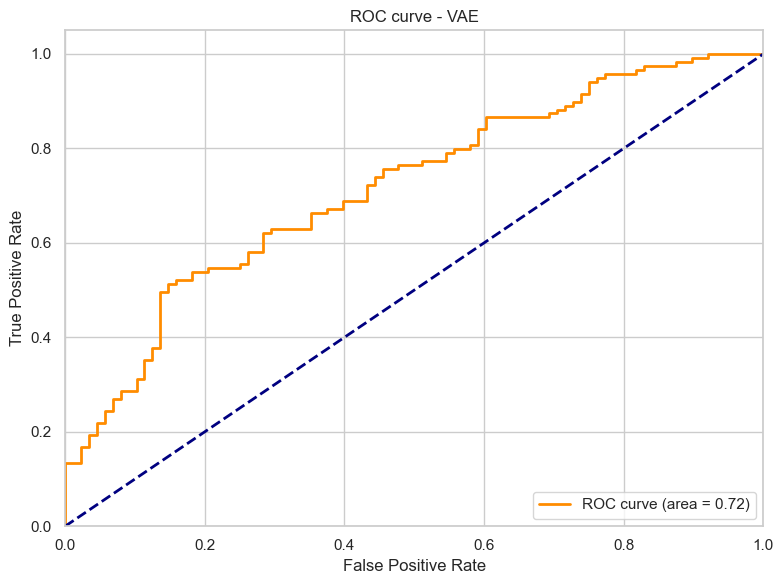

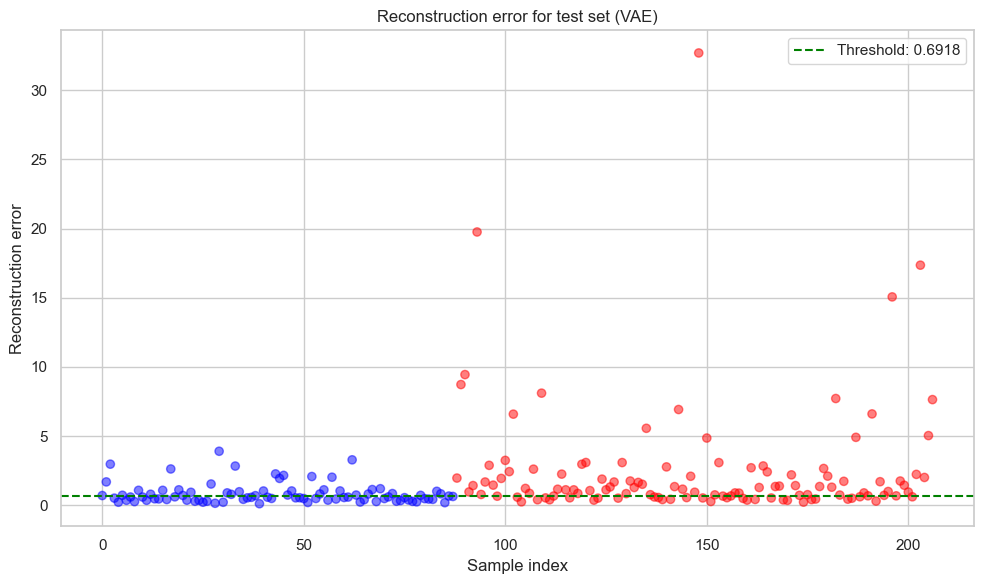

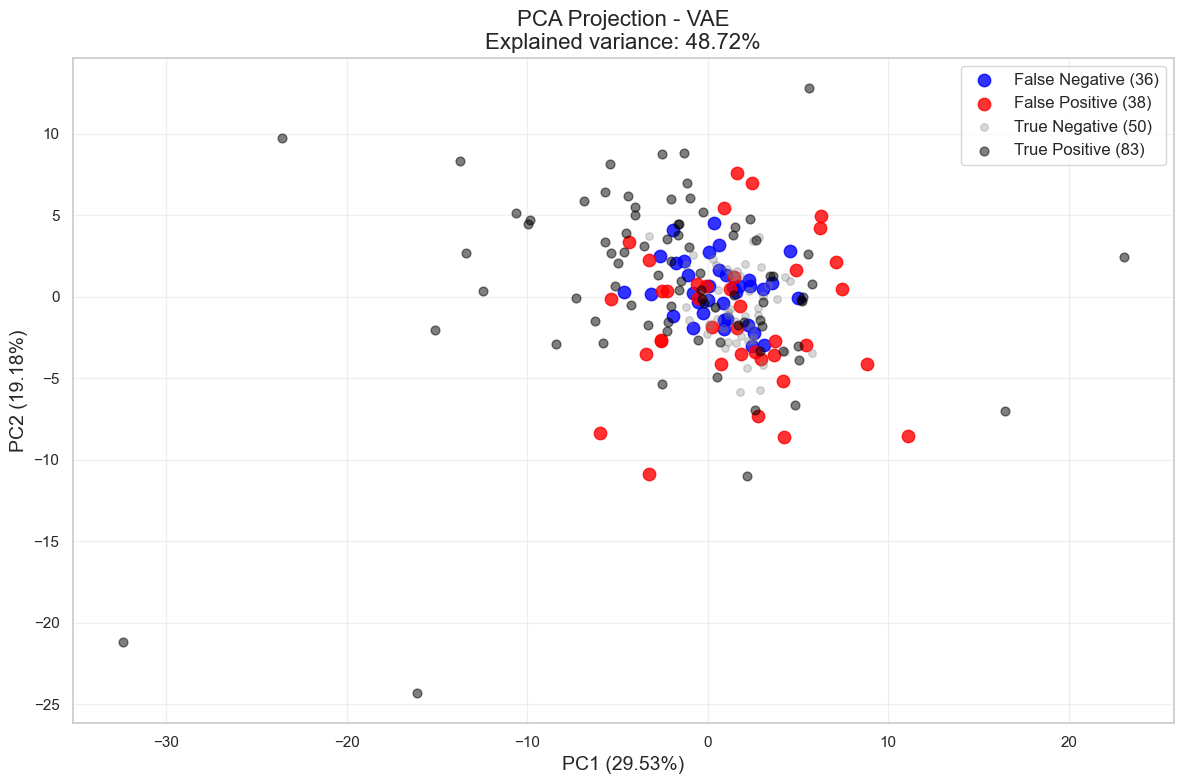

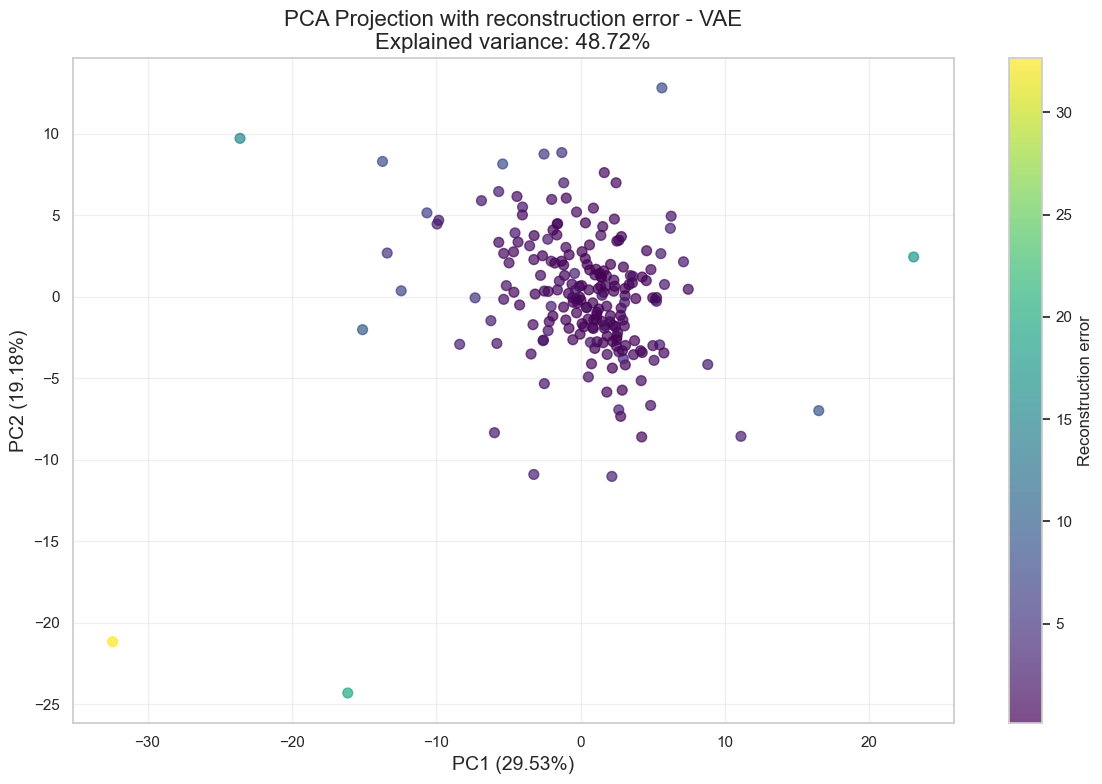

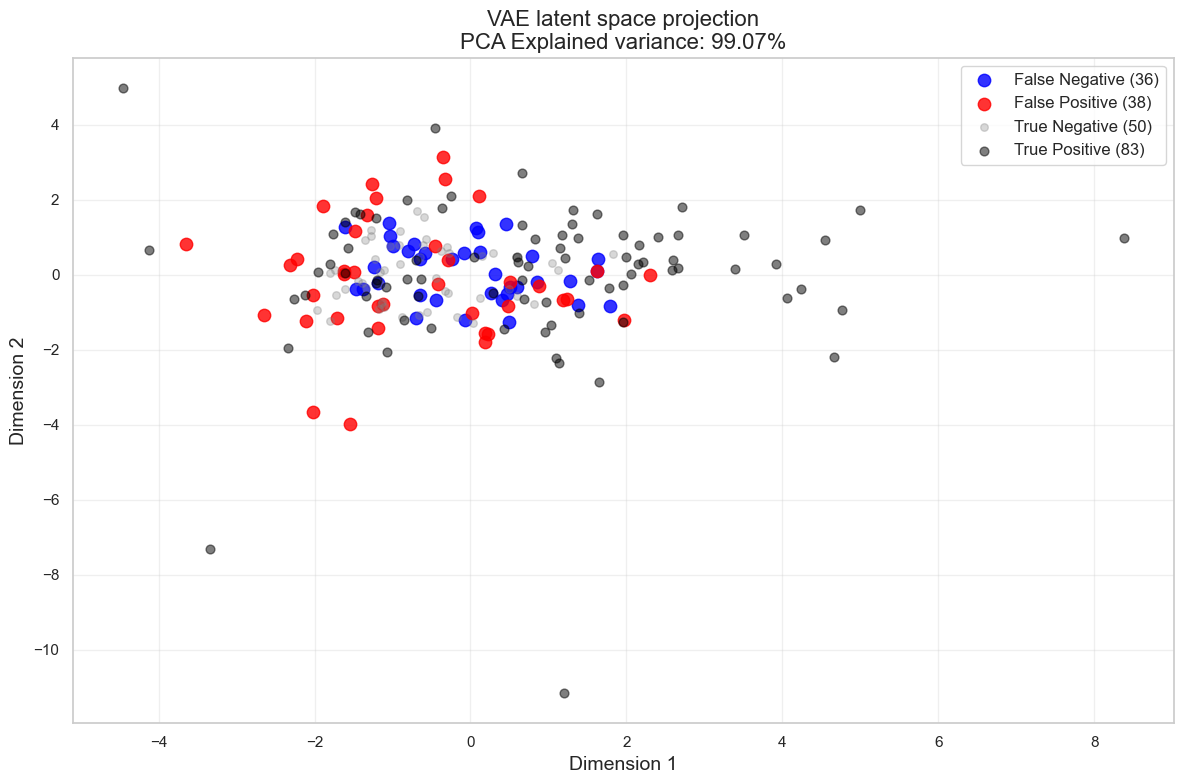

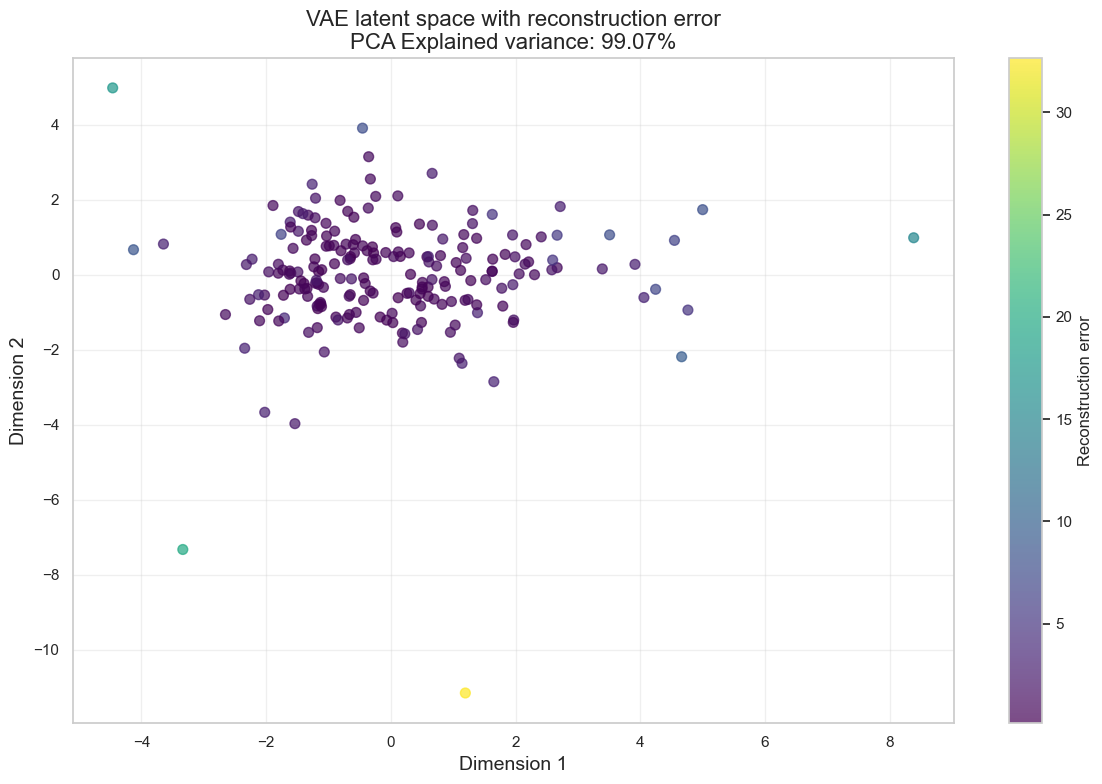


Performance comparison:
Model  Precision   Recall  F1 Score
  VAE    0.68595 0.697479  0.691667


In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

# Assumendo che X_train_scaled, X_cv_scaled, X_test_scaled, y_cross_val, y_test siano già definiti

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_cv_tensor = torch.FloatTensor(X_cv_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class VAE(nn.Module):
    def __init__(self, input_dim, encoding_dim=16):
        super(VAE, self).__init__()

        layer1_size = input_dim // 2
        layer2_size = layer1_size // 2
        layer1_size = max(layer1_size, encoding_dim * 2)
        layer2_size = max(layer2_size, encoding_dim)

        # Encoder
        self.encoder_fc1 = nn.Sequential(
            nn.Linear(input_dim, layer1_size),
            nn.BatchNorm1d(layer1_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer1_size, layer2_size),
            nn.BatchNorm1d(layer2_size),
            nn.ReLU(True),
            nn.Dropout(0.2)
        )
        self.fc_mu = nn.Linear(layer2_size, encoding_dim)
        self.fc_logvar = nn.Linear(layer2_size, encoding_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, layer2_size),
            nn.BatchNorm1d(layer2_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer2_size, layer1_size),
            nn.BatchNorm1d(layer1_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer1_size, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder_fc1(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

input_dim = X_train_scaled.shape[1]
encoding_dim = min(16, input_dim // 4)
model = VAE(input_dim, encoding_dim).to(device)
print(f"Encoding dimension: {encoding_dim}")
print(model)

criterion = nn.MSELoss(reduction='sum')  # sum over batch for ELBO
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE)
    MSE = criterion(recon_x, x)
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

def train_vae(model, train_loader, num_epochs=100, patience=10):
    best_loss = float('inf')
    no_improve_epochs = 0
    train_losses = []
    print("Training VAE...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data, _ in train_loader:
            optimizer.zero_grad()
            outputs, mu, logvar = model(data)
            loss = loss_function(outputs, data, mu, logvar)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), 'best_vae.pth')
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    model.load_state_dict(torch.load('best_vae.pth'))
    plt.figure(figsize=(10,6))
    plt.plot(train_losses)
    plt.title('VAE Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    return model

model = train_vae(model, train_loader, num_epochs=200, patience=20)

def compute_reconstruction_error_vae(model, data_tensor):
    model.eval()
    with torch.no_grad():
        reconstructions, _, _ = model(data_tensor)
        mse = ((reconstructions - data_tensor) ** 2).mean(dim=1).cpu().numpy()
    return mse

train_errors_VAE = compute_reconstruction_error_vae(model, X_train_tensor)
cv_errors_VAE = compute_reconstruction_error_vae(model, X_cv_tensor)
test_errors_VAE = compute_reconstruction_error_vae(model, X_test_tensor)

contamination = np.mean(y_cross_val)
print(f"Contamination rate from cross-validation set: {contamination:.4f}")

threshold_VAE = np.percentile(cv_errors_VAE, 100 * (1 - contamination))
print(f"Threshold for anomaly detection (VAE): {threshold_VAE:.6f}")

y_pred_VAE = (test_errors_VAE > threshold_VAE).astype(int)

def evaluate_vae(y_true, y_pred, reconstruction_errors, threshold):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print("\nVAE performance:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - VAE')
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, reconstruction_errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve - VAE')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.scatter(range(len(reconstruction_errors)), reconstruction_errors,
                c=['blue' if label == 0 else 'red' for label in y_true], alpha=0.5)
    plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold: {threshold:.4f}')
    plt.title('Reconstruction error for test set (VAE)')
    plt.xlabel('Sample index')
    plt.ylabel('Reconstruction error')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return precision, recall, f1, roc_auc

vae_metrics = evaluate_vae(y_test, y_pred_VAE, test_errors_VAE, threshold_VAE)

def visualize_vae_pca(X, y_true, y_pred, reconstruction_errors, threshold):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Actual'] = y_true
    pca_df['Predicted'] = y_pred
    pca_df['Error'] = reconstruction_errors

    pca_df['Category'] = 'Unknown'
    pca_df.loc[(y_true == 0) & (y_pred == 0), 'Category'] = 'True Negative'
    pca_df.loc[(y_true == 0) & (y_pred == 1), 'Category'] = 'False Positive'
    pca_df.loc[(y_true == 1) & (y_pred == 0), 'Category'] = 'False Negative'
    pca_df.loc[(y_true == 1) & (y_pred == 1), 'Category'] = 'True Positive'

    explained_variance = pca.explained_variance_ratio_
    total_variance = sum(explained_variance)

    plt.figure(figsize=(12, 8))
    colors = {'True Negative': 'gray', 'True Positive': 'black',
              'False Positive': 'red', 'False Negative': 'blue'}
    alphas = {'True Negative': 0.3, 'True Positive': 0.5,
              'False Positive': 0.8, 'False Negative': 0.8}
    sizes = {'True Negative': 30, 'True Positive': 40,
             'False Positive': 80, 'False Negative': 80}

    for category, group in pca_df.groupby('Category'):
        plt.scatter(group['PC1'], group['PC2'], color=colors[category],
                    alpha=alphas[category], s=sizes[category], label=f"{category} ({len(group)})")

    plt.title(f'PCA Projection - VAE\nExplained variance: {total_variance:.2%}', fontsize=16)
    plt.xlabel(f'PC1 ({explained_variance[0]:.2%})', fontsize=14)
    plt.ylabel(f'PC2 ({explained_variance[1]:.2%})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Error'],
                          cmap='viridis', alpha=0.7, s=50)
    plt.colorbar(scatter, label='Reconstruction error')
    plt.title(f'PCA Projection with reconstruction error - VAE\nExplained variance: {total_variance:.2%}', fontsize=16)
    plt.xlabel(f'PC1 ({explained_variance[0]:.2%})', fontsize=14)
    plt.ylabel(f'PC2 ({explained_variance[1]:.2%})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    model.eval()
    with torch.no_grad():
        mu, _ = model.encode(torch.FloatTensor(X).to(device))
        latent_vectors = mu.cpu().numpy()

    if latent_vectors.shape[1] > 2:
        pca_latent = PCA(n_components=2)
        latent_2d = pca_latent.fit_transform(latent_vectors)
        explained_var = pca_latent.explained_variance_ratio_
        total_var = sum(explained_var)
        title_suffix = f"\nPCA Explained variance: {total_var:.2%}"
    else:
        latent_2d = latent_vectors
        title_suffix = ""

    latent_df = pd.DataFrame(latent_2d, columns=['Dim1', 'Dim2'])
    latent_df['Actual'] = y_true
    latent_df['Predicted'] = y_pred
    latent_df['Error'] = reconstruction_errors

    latent_df['Category'] = 'Unknown'
    latent_df.loc[(y_true == 0) & (y_pred == 0), 'Category'] = 'True Negative'
    latent_df.loc[(y_true == 0) & (y_pred == 1), 'Category'] = 'False Positive'
    latent_df.loc[(y_true == 1) & (y_pred == 0), 'Category'] = 'False Negative'
    latent_df.loc[(y_true == 1) & (y_pred == 1), 'Category'] = 'True Positive'

    plt.figure(figsize=(12, 8))
    for category, group in latent_df.groupby('Category'):
        plt.scatter(group['Dim1'], group['Dim2'], color=colors[category],
                    alpha=alphas[category], s=sizes[category], label=f"{category} ({len(group)})")

    plt.title(f'VAE latent space projection{title_suffix}', fontsize=16)
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(latent_df['Dim1'], latent_df['Dim2'], c=latent_df['Error'],
                          cmap='viridis', alpha=0.7, s=50)
    plt.colorbar(scatter, label='Reconstruction error')
    plt.title(f'VAE latent space with reconstruction error{title_suffix}', fontsize=16)
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

visualize_vae_pca(X_test_scaled, y_test, y_pred_VAE, test_errors_VAE, threshold_VAE)

# Add VAE results to comparison
results_df = pd.DataFrame([
    ("VAE", vae_metrics[0], vae_metrics[1], vae_metrics[2])
], columns=['Model', 'Precision', 'Recall', 'F1 Score'])

print("\nPerformance comparison:")
print(results_df.sort_values('F1 Score', ascending=False).to_string(index=False))



### 🧪 COPOD Optimization Strategy (F1 Score)

This section applies the **COPOD (Copula-Based Outlier Detection)** method for unsupervised anomaly detection by:

- **Fitting COPOD on training data**, which models empirical tail probabilities without distributional assumptions
- **Computing anomaly scores** on test data based on extreme value theory principles
- **Setting an adaptive threshold** via percentile (based on estimated contamination) to classify outdary plots

Key benefits of COPOD:
- **No hyperparameters to tune**, making it suitable for automated pipelines
- Naturally handles high-dimensional data with strong theoretical grounding in statistics



COPOD performance:
Precision: 0.6807
Recall: 0.6807
F1 Score: 0.6807


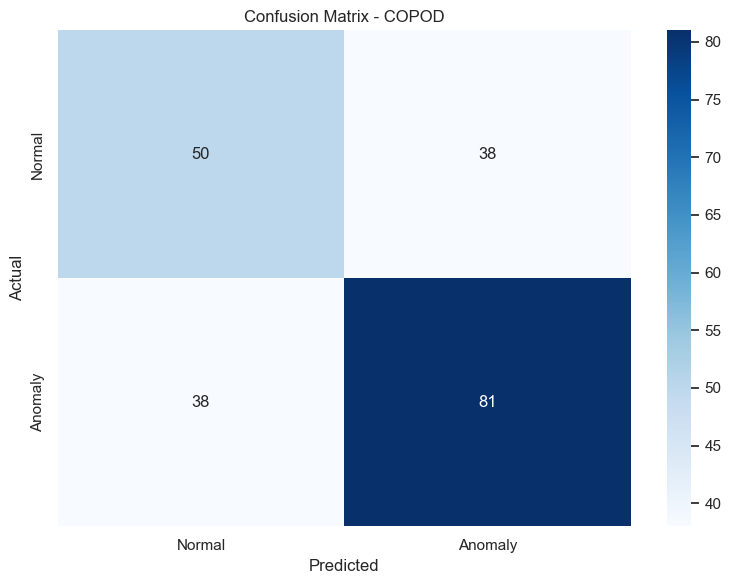

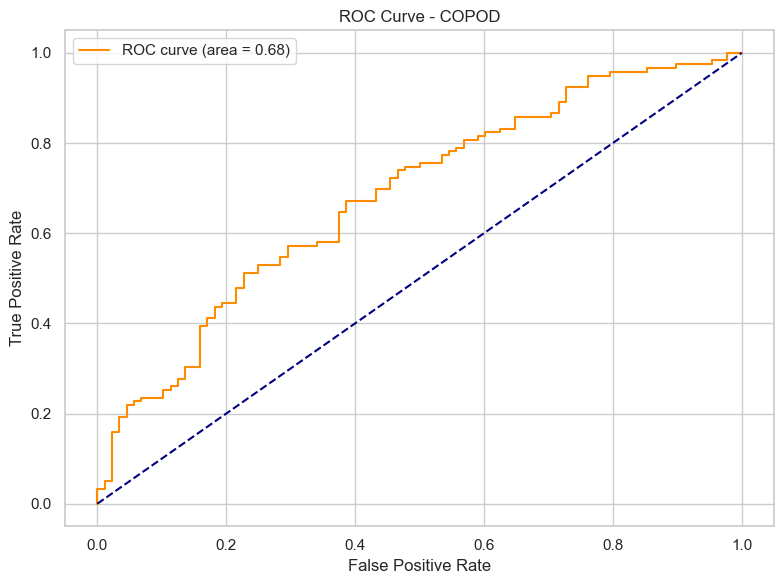

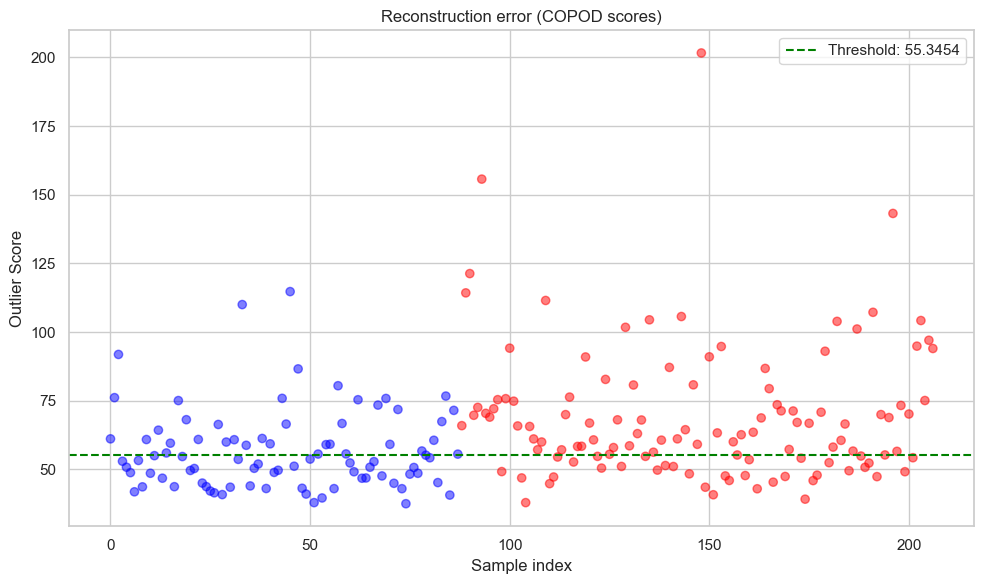

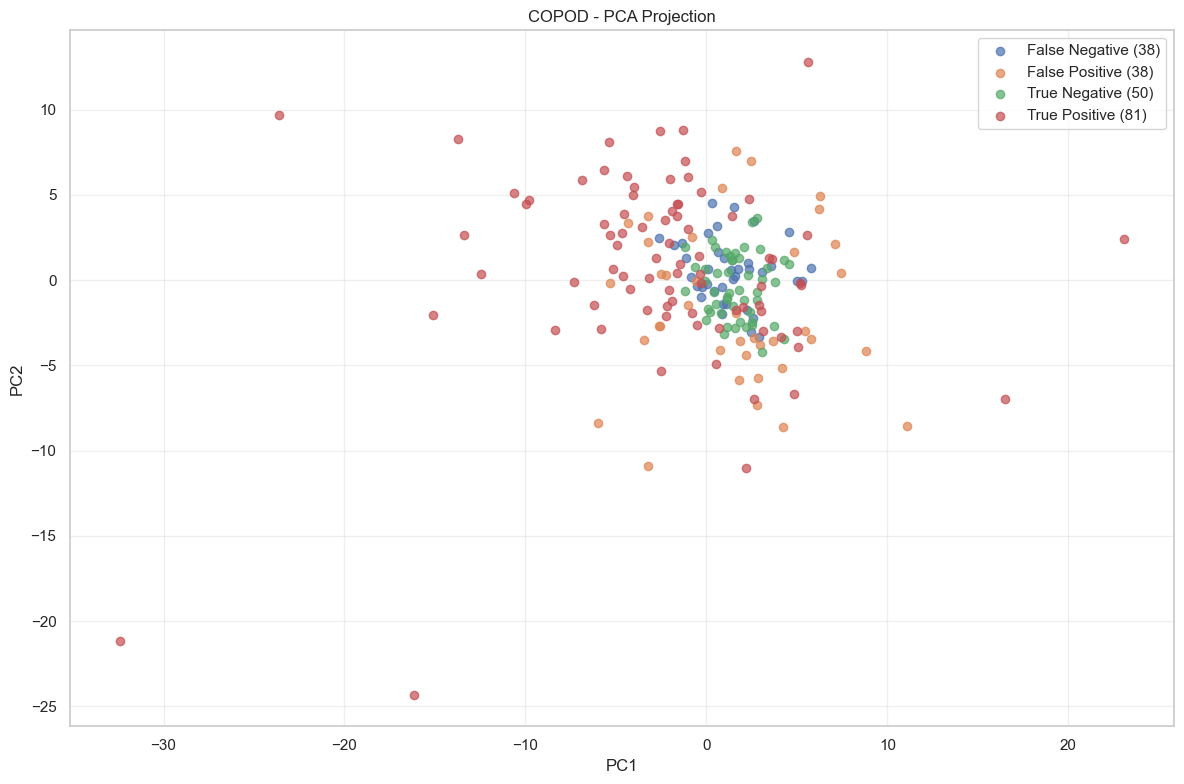

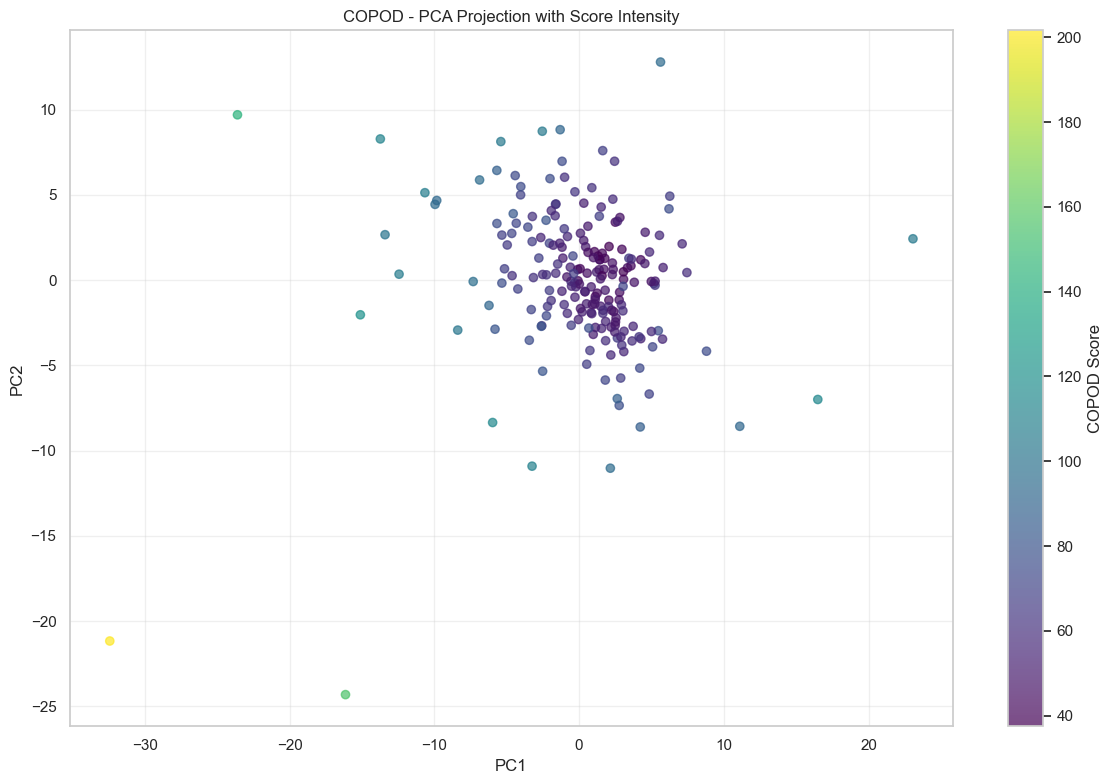

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.models.copod import COPOD
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA

# Fit the COPOD model
copod = COPOD()
copod.fit(X_train_scaled)

# Predict outliers on test set
y_test_scores = copod.decision_function(X_test_scaled)
threshold = np.percentile(y_test_scores, 100 * (1 - contamination))
y_pred_copod = (y_test_scores > threshold).astype(int)

# Evaluation
def evaluate_model(y_true, y_pred, scores, threshold, title='COPOD'):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n{title} performance:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(scores)), scores,
                c=['blue' if label == 0 else 'red' for label in y_true], alpha=0.5)
    plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold: {threshold:.4f}')
    plt.title(f'Reconstruction error (COPOD scores)')
    plt.xlabel('Sample index')
    plt.ylabel('Outlier Score')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return precision, recall, f1, roc_auc

# Call the evaluation
copod_metrics = evaluate_model(y_test, y_pred_copod, y_test_scores, threshold)

# PCA projection
def visualize_pca(X, y_true, y_pred, scores, threshold, title='COPOD'):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    df['Actual'] = y_true
    df['Predicted'] = y_pred
    df['Score'] = scores

    df['Category'] = 'Unknown'
    df.loc[(y_true == 0) & (y_pred == 0), 'Category'] = 'True Negative'
    df.loc[(y_true == 0) & (y_pred == 1), 'Category'] = 'False Positive'
    df.loc[(y_true == 1) & (y_pred == 0), 'Category'] = 'False Negative'
    df.loc[(y_true == 1) & (y_pred == 1), 'Category'] = 'True Positive'

    plt.figure(figsize=(12, 8))
    for category, group in df.groupby('Category'):
        plt.scatter(group['PC1'], group['PC2'], alpha=0.7, label=f"{category} ({len(group)})")

    plt.title(f'{title} - PCA Projection')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # With score heatmap
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(df['PC1'], df['PC2'], c=df['Score'], cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='COPOD Score')
    plt.title(f'{title} - PCA Projection with Score Intensity')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call the PCA visualization
visualize_pca(X_test_scaled, y_test, y_pred_copod, y_test_scores, threshold)



### 🔀 Ensemble Methods

This section implements an **ensemble method** by stacking predictions from multiple anomaly detectors using **logistic regression**:

- **Base models**: Individual unsupervised and deep learning models (e.g., ISO, GMM, LOF, AE, VAE, COPOD, etc.) generate binary predictions.
- **Meta-model (stacking)**: A logistic regression model is trained on combinations of 2, 3, and 4 model predictions to learn how to best combine them.
- **Training target**: True labels (`y_test`) are used to guide the logistic regression in learning optimal voting weights.
- **Evaluation metrics**: For each model combination, we compute:
  - **Precision**, **Recall**, **F1-score**, **AUC**
  - **Mean error correlation** among models — lower correlation implies greater diversity and better ensemble performance.

**Why this matters**:
- Ensemble stacking leverages the **strengths of diverse models** while reducing individual weaknesses.
- **Low error correlation** between models improves generalization by combining complementary decision patterns.



 Best combination of size 2 :

🔹 Models: GMM + XGBoost
F1: 0.7635 | Recall: 0.7731 | Precision: 0.7541 | AUC: 0.7627
Average error correlation: 0.2744


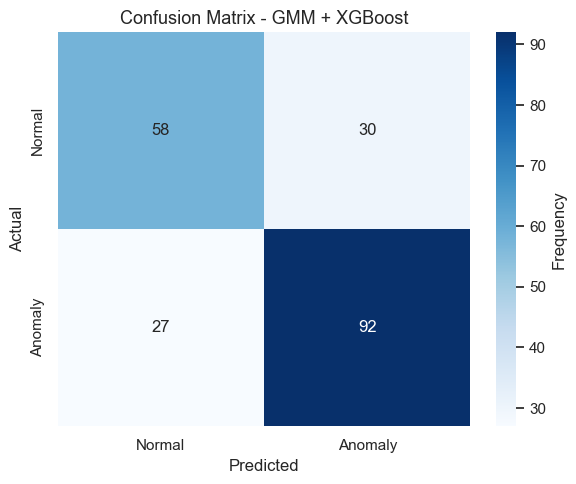


 Best combination of size 3 :

🔹 Models: GMM + SVM + XGBoost
F1: 0.7631 | Recall: 0.7983 | Precision: 0.7308 | AUC: 0.7826
Average error correlation: 0.3674


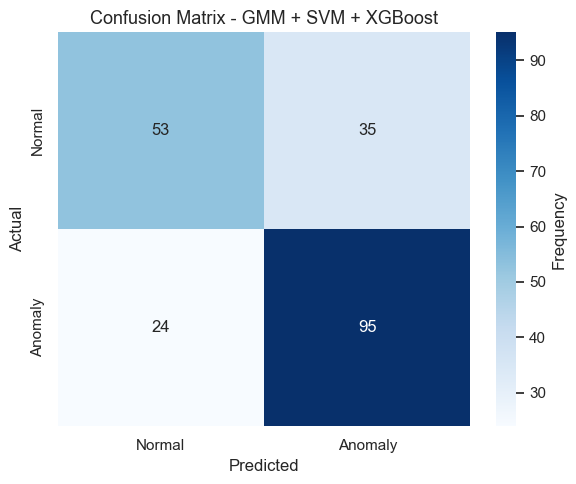


 Best combination of size 4 :

🔹 Models: GMM + SVM + COPOD + XGBoost
F1: 0.7686 | Recall: 0.8235 | Precision: 0.7206 | AUC: 0.7880
Average error correlation: 0.4246


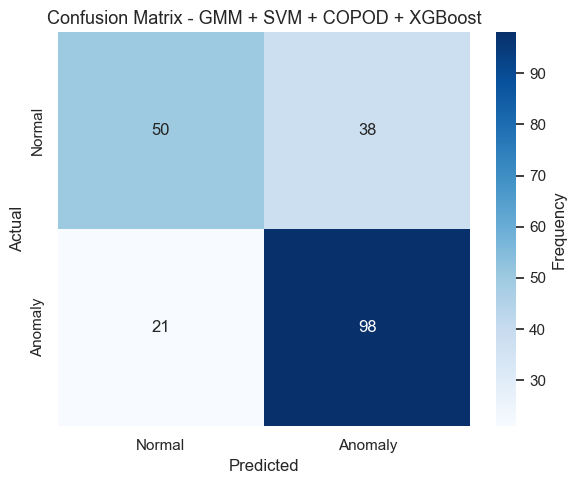

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from itertools import combinations

# Make sure the predictions have the same shape as y_test
assert len(iso_pred) == len(y_test)
assert len(y_pred) == len(y_test)
assert len(gmm_pred) == len(y_test)
assert len(ocsvm_pred) == len(y_test)
assert len(lof_pred) == len(y_test)

# Dictionary with model predictions
model_preds = {
    'ISO': iso_pred,
    'AE': y_pred,
    'GMM': gmm_pred,
    'OCSVM': ocsvm_pred,
    'LOF': lof_pred,
    'VAE' : y_pred_VAE,
    'SVM': y_pred_SVM,
    'COPOD' : y_pred_copod,
    'XGBoost' : y_pred_XG
}


# Function to calculate Precision and Recall manually
def calc_precision_recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    return precision, recall


# Function to calculate F1 score as 2*(Precision * Recall) / (Precision + Recall)
def calc_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


# Calculate errors for correlation (1 = error, 0 = correct)
errors_df = pd.DataFrame({name: (pred != y_test).astype(int) for name, pred in model_preds.items()})
error_corr = errors_df.corr()

# Results list
results = []

from itertools import combinations


for combo_size in [2, 3, 4]:
    for combo in combinations(model_preds.keys(), combo_size):
        probas = np.column_stack([model_preds[name] for name in combo])
        clf = LogisticRegression(solver='liblinear')
        clf.fit(probas, y_test)
        final_pred_prob = clf.predict_proba(probas)[:, 1]
        final_pred = (final_pred_prob > 0.5).astype(int)

        precision, recall = calc_precision_recall(y_test, final_pred)
        f1 = calc_f1(precision, recall)
        roc_auc = roc_auc_score(y_test, final_pred_prob)

        sub_corr = error_corr.loc[combo, combo]
        if combo_size > 1:
            mean_corr = (sub_corr.values[np.triu_indices(combo_size, 1)]).mean()
        else:
            mean_corr = 0

        results.append({
            'Models': combo,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'AUC': roc_auc,
            'MeanErrorCorr': mean_corr,
            'Prediction': final_pred,
            'ComboSize': combo_size
        })

results_df = pd.DataFrame(results)


def plot_result(row):
    print(f"\n🔹 Models: {' + '.join(row['Models'])}")
    print(f"F1: {row['F1']:.4f} | Recall: {row['Recall']:.4f} | Precision: {row['Precision']:.4f} | AUC: {row['AUC']:.4f}")
    print(f"Average error correlation: {row['MeanErrorCorr']:.4f}")

    cm = confusion_matrix(y_test, row['Prediction'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'],
                cbar_kws={'label': 'Frequency'})
    plt.title(f"Confusion Matrix - {' + '.join(row['Models'])}", fontsize=13)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


for size in [2, 3, 4]:
    subset = results_df[results_df['ComboSize'] == size]
    best_row = subset.loc[subset['MeanErrorCorr'].idxmin()]
    print(f"\n Best combination of size {size} :")
    plot_result(best_row)


We can notice that all the methods **outperform** the single methods for almost every metrics, showing us the robustness of ensembling models with different aproaches.


 Best combination of size 2 :

🔹 Models: SVM + XGBoost
F1: 0.7803 | Recall: 0.8655 | Precision: 0.7103 | AUC: 0.7549
Average error correlation: 0.4881


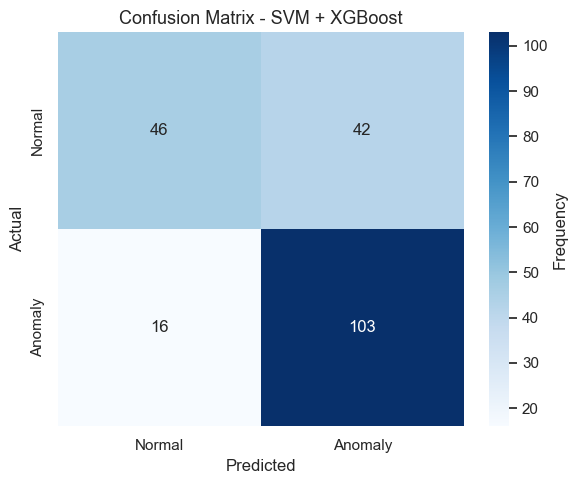


 Best combination of size 3 :

🔹 Models: GMM + SVM + COPOD
F1: 0.7829 | Recall: 0.8487 | Precision: 0.7266 | AUC: 0.7465
Average error correlation: 0.4673


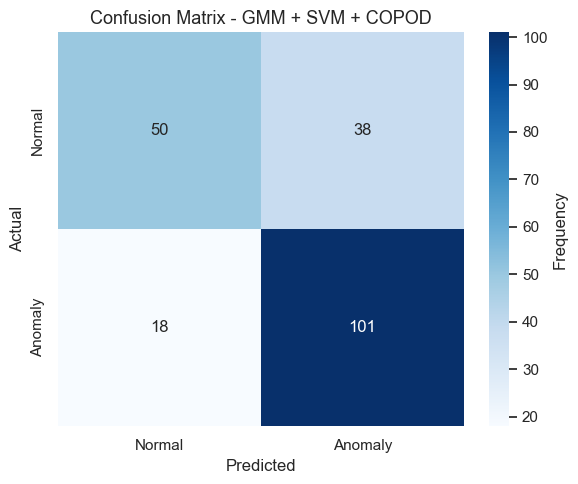


 Best combination of size 4 :

🔹 Models: AE + GMM + SVM + COPOD
F1: 0.7829 | Recall: 0.8487 | Precision: 0.7266 | AUC: 0.7475
Average error correlation: 0.5457


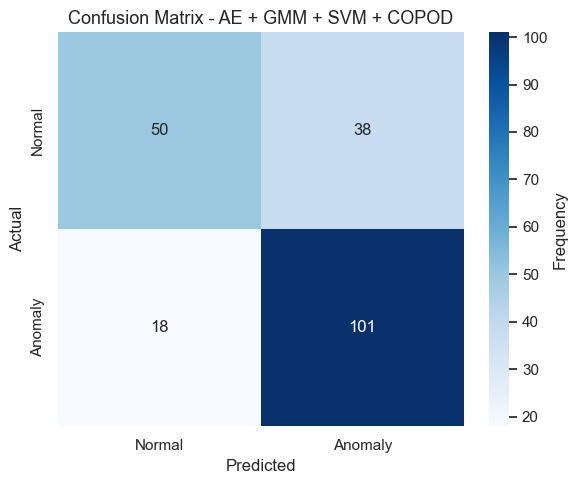

In [84]:
for size in [2, 3, 4]:
    subset = results_df[results_df['ComboSize'] == size]
    best_row = subset.loc[subset['F1'].idxmax()]
    print(f"\n Best combination of size {size} :")
    plot_result(best_row)

We can also show how maxing other metrics such as F1 Score gives also very good results, but **not so much better** than the previous ones, which are very good and robust.
However someone could decide to maximize another metric, such as recall or precision, **depending on the needs of the situation** , since ensembling will provide good results again.